# Anomaly Detection - Insurance Data - Unsupervised 

## For Professor Amato - Hardware and Software for Big Data Mod B

### Group Members
- Anna Guarino
- Gaetano Guarino 
- Daniel Fynn 

In [ ]:
import pandas as pd
import numpy as np
import string
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from numpy import quantile, where, random


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/healthcare_providers.csv")


In [ ]:
display(data.head())
data.info()

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,...,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,...,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   index                                                     100000 non-null  int64  
 1   National Provider Identifier                              100000 non-null  int64  
 2   Last Name/Organization Name of the Provider               100000 non-null  object 
 3   First Name of the Provider                                95745 non-null   object 
 4   Middle Initial of the Provider                            70669 non-null   object 
 5   Credentials of the Provider                               92791 non-null   object 
 6   Gender of the Provider                                    95746 non-null   object 
 7   Entity Type of the Provider                               100000 non-null  object 
 8   Stree

# Preprocessing

In [ ]:
#Issue when attempting to update the values to floats, integers, as there are commas within the string. 

def removecomma(column):
    for data2 in range(len(column)):         
        if "," in column[data2]: 
            column[data2] = column[data2].replace(",","")

    return column

### Alter some of the value columns, from object to numeric after removing commas from the string first

In [ ]:
#removing the commas in the numerical columns and changing type to numeric 

#numerucal values, that need updating from an object type 

updated_cols = ["Number of Services", "Number of Medicare Beneficiaries",  
               "Number of Distinct Medicare Beneficiary/Per Day Services","Average Medicare Allowed Amount", 
               "Average Submitted Charge Amount", "Average Medicare Payment Amount", "Average Medicare Standardized Amount"]

for name in updated_cols:

    
    data[name] = removecomma(data[name])
    data[name] = pd.to_numeric(data[name])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Generalising Credentials List - was later removed for complexity

### there were many with different formating including full stops between arconyms or dasshes 

#### The below cell generalises them 

In [ ]:
#drop cleaning credentials, as we cut later 

'''
# Cleaning Credentials List
#Noticed there are inconsistencies in the titles, including dots between and not

credential = data.groupby(["Credentials of the Provider"]).size()
display(credential)

#first of all remove all grammar marks, leaving in spaces to recognize different qualifications of one person 

for i in range(len(data["Credentials of the Provider"])):
    replacement = ""
    #print(i, data["Credentials of the Provider"][int(i)])
    
    if pd.notna(data["Credentials of the Provider"][int(i)]):

    
        if data["Last Name/Organization Name of the Provider"][int(i)] in data["Credentials of the Provider"][int(i)]:

            data["Credentials of the Provider"][int(i)] = np.nan

        if pd.notna(data["Credentials of the Provider"][int(i)]):


            for char in data["Credentials of the Provider"][int(i)]:
                if char in string.ascii_letters: #+ " " + "-":
                    replacement = replacement + char
            #replacement.upper()
            data["Credentials of the Provider"][int(i)] = replacement.upper()
    
credential = data.groupby(["Credentials of the Provider"]).size()
display(credential)

#reduced the amount of possible credentials, from 1854 to 1138, and removed mistakes with users putting name
'''
""

''

### Dropping features believed to be irrelevant features

In [ ]:
#These are the decided drop columns, that we believe won't provide value for the investigation, and the reasons are 
#next to it. 

dropped_columns =["index", #meaningless to the data
                  "Last Name/Organization Name of the Provider", #not relevant
                  "First Name of the Provider",
                  "Middle Initial of the Provider",
                  "Gender of the Provider", #is it more likely to have a male or female fradulant claim
                  "Street Address 1 of the Provider", #not necessary 
                  "Street Address 2 of the Provider",
                  "City of the Provider", #multiple city names from different regions
                  "HCPCS Description", #same as HCPCS Code
                  "National Provider Identifier" #just a reference number, essentially a unique ID 
                 ]
data = data.drop(dropped_columns, axis = 1)

### checking for null values

#### Originally tried to inperpolate the credentials fo the provider, but it was later dropped for complexity 

In [ ]:
display(data.isnull().sum())

#Only credentials of the provider gives null values. According to the meta data, credentials can only be given by non
#organisations

# Credentials of the provider is cut later, so remove this part

'''

occur = data.groupby(['Entity Type of the Provider']).size()
display(occur)

#There are some I values that are missing not based on entity type




for i in range(len(data["Credentials of the Provider"])):
  if  pd.isna(data["Credentials of the Provider"][i]) and data["Entity Type of the Provider"][i] == "I":
    data["Credentials of the Provider"][i] = data["Credentials of the Provider"].mode()[0]

display(data.isnull().sum())
'''
""

Credentials of the Provider                                 7209
Entity Type of the Provider                                    0
Zip Code of the Provider                                       0
State Code of the Provider                                     0
Country Code of the Provider                                   0
Provider Type                                                  0
Medicare Participation Indicator                               0
Place of Service                                               0
HCPCS Code                                                     0
HCPCS Drug Indicator                                           0
Number of Services                                             0
Number of Medicare Beneficiaries                               0
Number of Distinct Medicare Beneficiary/Per Day Services       0
Average Medicare Allowed Amount                                0
Average Submitted Charge Amount                                0
Average Medicare Payment 

''

### Reducing complexity of zip values

#### Ended up removing because ZIP value was later dropped for complexity

Generalising from a 9 figure ZIP to a 5 figure


In [ ]:
#removign zip reducing categories, as we cut it later 

'''
data["Zip Code of the Provider"] = data["Zip Code of the Provider"].astype('int')

for i in range(len(data["Zip Code of the Provider"])):
  if data['Country Code of the Provider'][i] != "JP" and len(str(data["Zip Code of the Provider"][i]))>5: #Japan has a zip code of length 7
    data["Zip Code of the Provider"][i] = pd.to_numeric(str(data["Zip Code of the Provider"][i])[:-4])
    if len(str(data["Zip Code of the Provider"][i]))>5:
      print(data["Zip Code of the Provider"][i])
'''
""

''

### Changing binary categorical variables into binary values 

In [ ]:
# make values binary that have binary values
#unsure what to do with other categories, other than one hot encoding, but want to ensure that is necessay

bin_cols = ["Entity Type of the Provider", "Medicare Participation Indicator", "Place of Service",  "HCPCS Drug Indicator"]

cat_cols =["Credentials of the Provider", # 1139 categories
          "Zip Code of the Provider", #10760
          "State Code of the Provider", #58
          "Country Code of the Provider", #4
          "Provider Type", #90
          "HCPCS Code" #2631 
           ]

#print(len(data["Credentials of the Provider"].unique()))
#print(len(data["Zip Code of the Provider"].unique()))
#print(len(data["State Code of the Provider"].unique()))
#print(len(data["Provider Type"].unique()))
#print(len(data["HCPCS Code"].unique()))


for name in bin_cols:
  data[name] = data[name].astype('category')
  data[name] = data[name].cat.codes

display(data.dtypes)

Credentials of the Provider                                  object
Entity Type of the Provider                                    int8
Zip Code of the Provider                                    float64
State Code of the Provider                                   object
Country Code of the Provider                                 object
Provider Type                                                object
Medicare Participation Indicator                               int8
Place of Service                                               int8
HCPCS Code                                                   object
HCPCS Drug Indicator                                           int8
Number of Services                                          float64
Number of Medicare Beneficiaries                              int64
Number of Distinct Medicare Beneficiary/Per Day Services      int64
Average Medicare Allowed Amount                             float64
Average Submitted Charge Amount                 

### Removing overly complicated features before one-hot encoding

### Creating df1, df2 and df3 

Cannot keep all of the categorical variables for one hot encoding, we have decided to simplify, and generalise the set by dropping zip code, as a more general form of this is the state code, and also drop the credentials, as irrelevant, and the HSCPS code as a specification of provider type. 

Also may run two different sets, one with state, and the other with provider type just for ease 


In [ ]:
cat_cols1 =["Credentials of the Provider", # 1139 categories
          "Zip Code of the Provider", #10760
          "State Code of the Provider", #58
          "HCPCS Code" #2631 
           ]


cat_cols2 =["Credentials of the Provider", # 1139 categories
          "Zip Code of the Provider", #10760
          "Provider Type", #90
          "HCPCS Code" #2631 
           ]



df1 = data.drop(cat_cols1, axis = 1) # with provider type
df2 = data.drop(cat_cols2, axis = 1) # with state code
df3 = data.drop(cat_cols2 + cat_cols1, axis = 1) # no large catgorical variables 

df1 = pd.get_dummies(df1)#, columns=[cat_cols1])
df2 = pd.get_dummies(df2)#, columns=[cat_cols2])
df3 = pd.get_dummies(df3)#, columns=[cat_cols2])


In [ ]:
#Renaming headers so they dont have spaces 


def rename_headers(df):
  df_new = df.copy()
  columns1 = df_new.columns

  new_column = []
  for column in columns1:
    new_str = ""
    for char in column:
      if char in string.ascii_letters:
        new_str = new_str + char
    new_column.append(new_str)

  df_new.columns = new_column
  return df_new

Renaming column heading so there arent spaces


In [ ]:
df1 = rename_headers(df1)

df2 = rename_headers(df2)

df3 = rename_headers(df3)

# Data Exploration 

### Visual representation of the numerical columns

#### Show a mode to the left and a right tail on all data, showing the average amounts are quite low, but there are rare but large events 

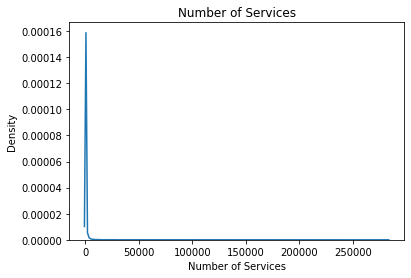

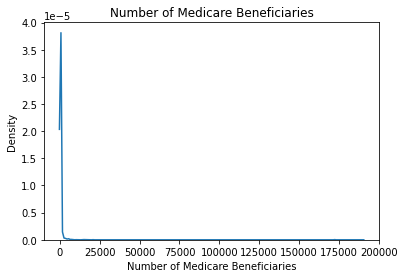

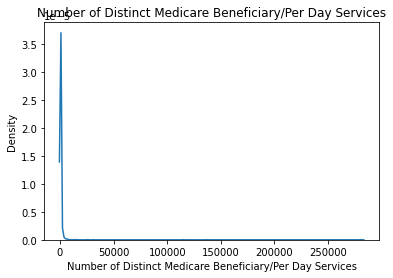

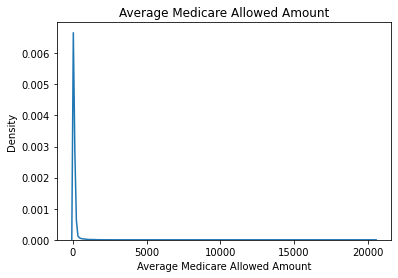

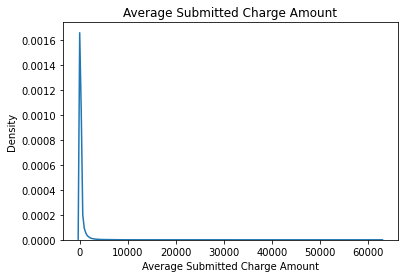

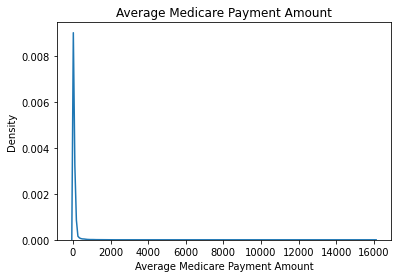

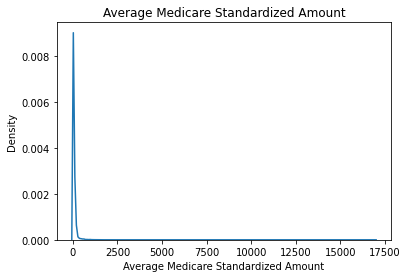

In [ ]:
#distribution of all points for numerical variables 

for name in updated_cols:

    #plt.plot(data[name]) # index against value 
    
    #plt.bar(np.arange(len( data[name])) , data[name].sort_values())

    plt.title(name)
    #plt.show()

    sns.kdeplot(data[name])
    plt.show()
  
#Looks like  a uniform distribution

### Graphing the binary variables as a separate colour for AverageSubmittedAmount

#### Also showing some QQ plots looking for normality

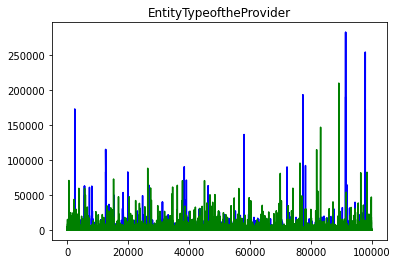

''

In [ ]:
#graph EntityTypeoftheProvider


df_graph1 = df1[df1.EntityTypeoftheProvider ==1]
df_graph2 = df1[df1.EntityTypeoftheProvider ==0]


plt.plot(df_graph1, color = "blue") # index against value 
plt.plot(df_graph2, color = "green")
plt.title("EntityTypeoftheProvider")
plt.show()


# QQ plots
'''
stats.probplot(df_graph1["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()
stats.probplot(df_graph2["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()
'''
""

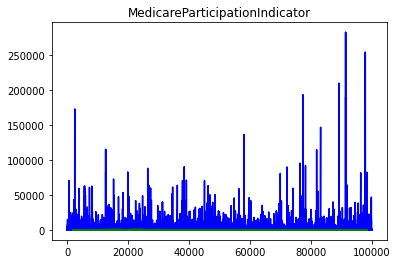

99969


In [ ]:
# graph MedicareParticipationIndicator

df_graph1 = df1[df1.MedicareParticipationIndicator ==1]
df_graph2 = df1[df1.MedicareParticipationIndicator ==0]

plt.plot(df_graph1, color = "blue") # index against value 
plt.plot(df_graph2, color = "green")
plt.title("MedicareParticipationIndicator")
plt.show()

#very weird graph 

print(df1["MedicareParticipationIndicator"].sum()) 
#99969 vs 31 heavily weighted toward being a practitioner 



#previous question
#should we split the data between individuals and organisation, to so if this lessens the discrepency of the spread of data?
#i think that the organisation points do have higehr peaks, but there is still a large discrpenacy for individuals, for 3 points, so won't worsen too much

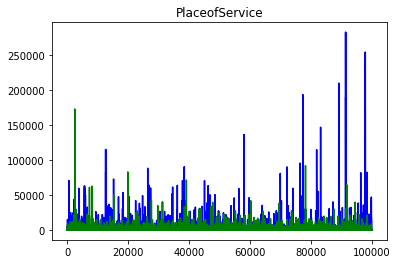

''

In [ ]:
#Graph PlaceofService

df_graph1 = df1[df1.PlaceofService ==1]
df_graph2 = df1[df1.PlaceofService ==0]

plt.plot(df_graph1, color = "blue") # index against value 
plt.plot(df_graph2, color = "green")
plt.title("PlaceofService")
plt.show()

'''
display(df_graph1.describe())
display(df_graph2.describe())

stats.probplot(df_graph1["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df_graph2["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()
'''
""

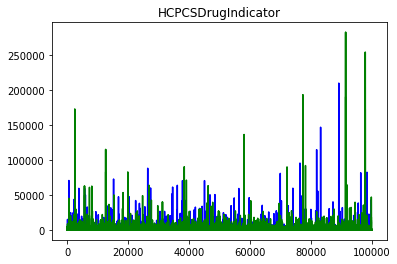

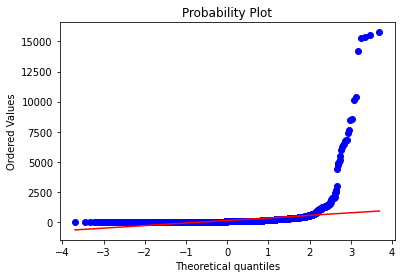

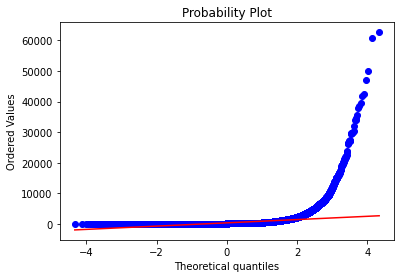

In [ ]:
# Graph HCPCSDrugIndicator

df_graph1 = df1[df1.HCPCSDrugIndicator ==1]
df_graph2 = df1[df1.HCPCSDrugIndicator ==0]

plt.plot(df_graph1, color = "blue") # index against value 
plt.plot(df_graph2, color = "green")
plt.title("HCPCSDrugIndicator")
plt.show()

#display(df_graph1.describe())
#display(df_graph2.describe())

stats.probplot(df_graph1["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df_graph2["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()

### Graph of Distrubutions of all continious variables

#### Can see that they are all heavily left skewed  with a strong right tail 

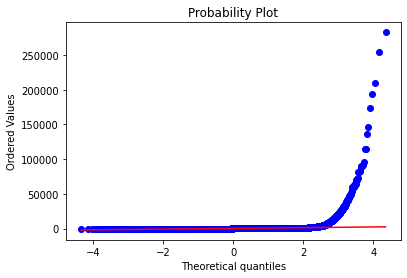

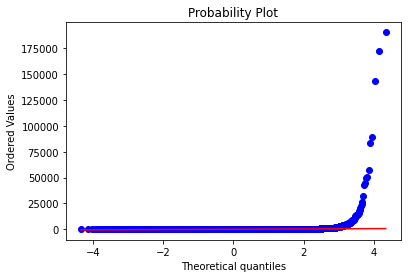

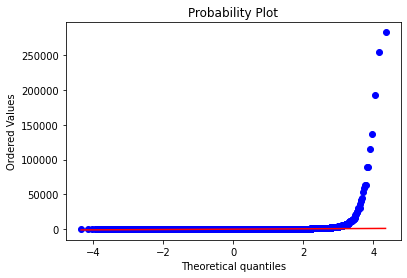

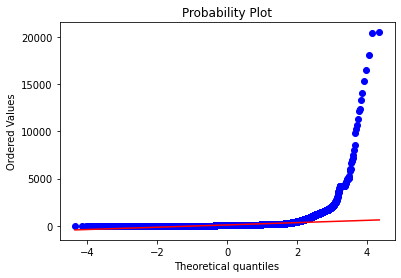

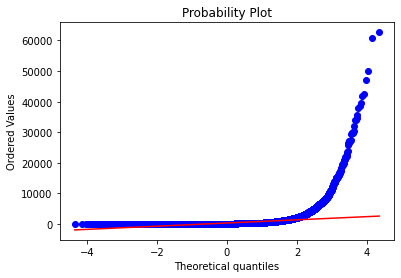

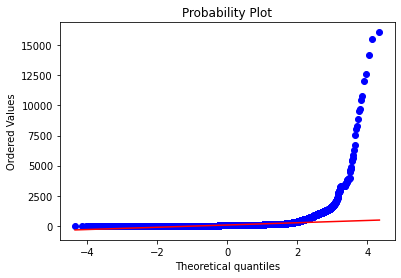

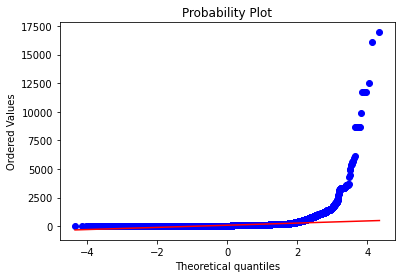

In [ ]:
stats.probplot(df1["NumberofServices"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["NumberofMedicareBeneficiaries"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["NumberofDistinctMedicareBeneficiaryPerDayServices"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["AverageMedicareAllowedAmount"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["AverageSubmittedChargeAmount"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["AverageMedicarePaymentAmount"], dist ="norm", plot=pylab)
pylab.show()

stats.probplot(df1["AverageMedicareStandardizedAmount"], dist ="norm", plot=pylab)
pylab.show()


#data points do not have a normal distribution for the whole range 

### Looking at the box plot for the some of the data, seeing the same spread in values

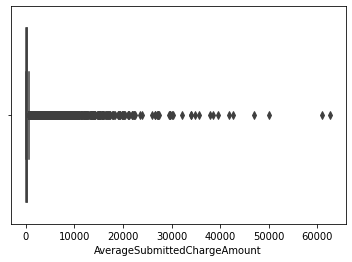

In [ ]:
sns.boxplot(x =df1["AverageSubmittedChargeAmount"] )

### Graph for the frequency of occurances of different HSPC Codes

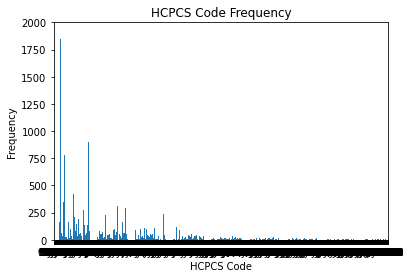

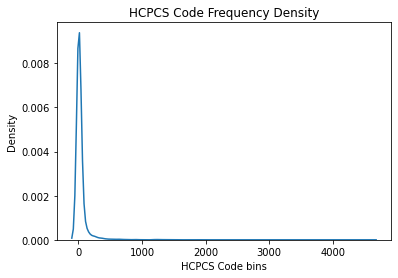

In [ ]:
dictionary3 = {}
for i in range(len(data["HCPCS Code"])):
    if data["HCPCS Code"][i] in dictionary3:
        dictionary3[data["HCPCS Code"][i]] += 1
    else:
        dictionary3[data["HCPCS Code"][i]] = 1
    

plt.bar(dictionary3.keys(),dictionary3.values())
plt.xlim(0,2000)
plt.ylim(0, 2000)
plt.ylabel("Frequency")
plt.xlabel("HCPCS Code")
plt.title("HCPCS Code Frequency")
plt.show()

sns.kdeplot(dictionary3.values())
plt.xlabel("HCPCS Code bins")
plt.title("HCPCS Code Frequency Density")
plt.show()

### Graph comparing the average subitted amount with the average for that HSPCS Code

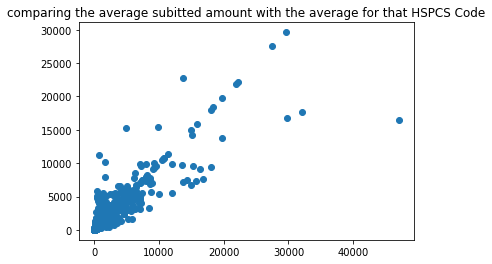

In [ ]:
#Comparring the average submitd amount with the average charge amount. 

descriptors = data.groupby(["HCPCS Code"]).mean()


dictionary2 = {}

for d in range(len(data["HCPCS Code"])):
    dictionary2[data["HCPCS Code"][d]] = [data["Average Submitted Charge Amount"][d] -descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][d]],
                                                 data["Average Submitted Charge Amount"][d], 
                                                descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][d]]]


new_list = dictionary2.values()

x = []
y =[]

for val in new_list:
    x.append(abs(val[1]))
    y.append(val[-1])

plt.plot(x,y, marker = "o", linestyle = "")
#plt.ylim(0,6000)
#plt.xlim(0,6000)
plt.title("Average Submitted Charge Amount vs Average Submitted Charge Amount per HCPCS code")
plt.show()


### Graph of the difference between the average submitted charge amount and the averafe for that HSPCS Code

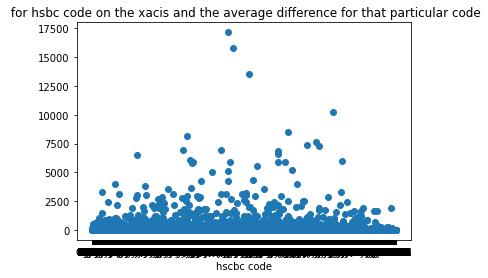

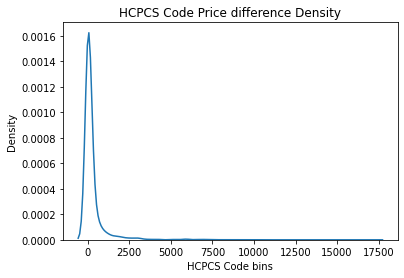

In [ ]:
# reattempt at the above graph using a similar mathod to below, for hsbc code on the xacis and the average difference for that particular code


dictionary5 ={}

for i in range(len(data["HCPCS Code"])):
    #if data["Country Code of the Provider"][i] != "JP": #Japan ruins the graph a bit by having 7 digits
    if data["HCPCS Code"][i] in dictionary5:
        dictionary5[data["HCPCS Code"][i]] += [abs(descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][i]] - data["Average Submitted Charge Amount"][i])]
      
    else:
        dictionary5[data["HCPCS Code"][i]] = [abs(descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][i]]  - data["Average Submitted Charge Amount"][i] ) ]

#print(dictionary5)
x = [val for val in dictionary5.keys()]
y=[sum(val)/len(val) for val in dictionary5.values()]


plt.plot(x,y, marker = "o", linestyle = "")
#plt.ylim(0,6000)
#plt.xlim(0,6000)
plt.title(" for hsbc code on the xacis and the average difference for that particular code")
plt.xlabel("hscbc code")
plt.show()

sns.kdeplot(y)
plt.xlabel("HCPCS Code bins")
plt.title("HCPCS Code Price difference Density")
plt.show()


### Graph for the Graph of the difference between the average submitted charge amount and the averafe for that HSPCS Code organised by ZIP code

#### Some analysis for the zip code of the higher cost differences 

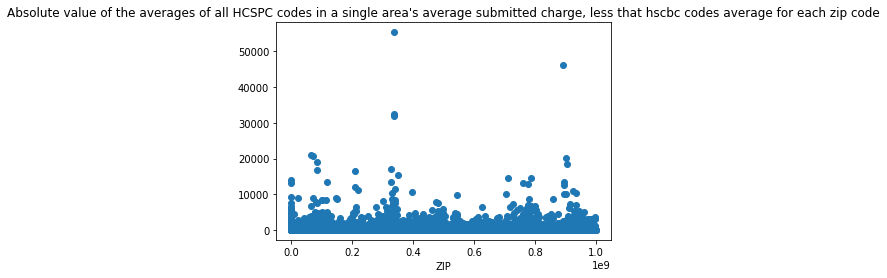

[[55366.4075025375, 336061606.0], [46330.27895654934, 890524184.0], [32552.38135915577, 337653550.0], [31833.755445549996, 336075810.0], [20986.261484636365, 64883926.0], [20763.94402890263, 70292134.0], [20266.318259962107, 900174807.0], [19159.094945499997, 83303214.0], [18360.33946120357, 904041811.0], [17193.51369485, 326054212.0]]


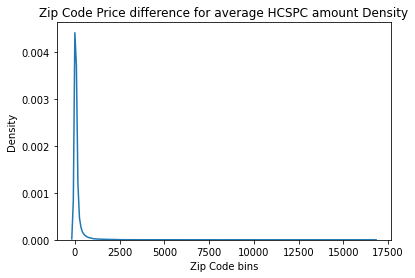

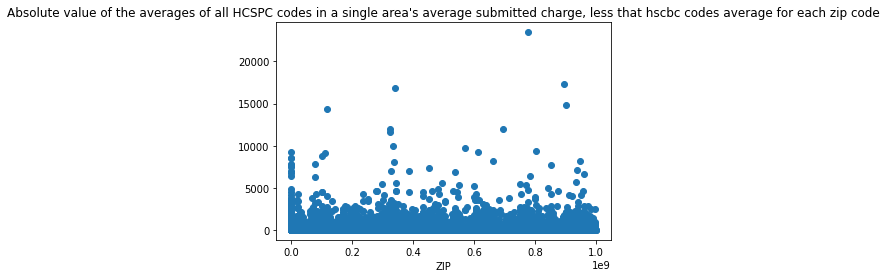

[[23467.33208333375, 778023475.0], [17278.4285715, 895214833.0], [16861.5, 339071849.0], [14872.22222222222, 902111838.0], [14393.75, 117722900.0], [12019.271081926001, 693614602.0], [11979.379059742001, 322164392.0], [11659.226581533332, 323472300.0], [9975.0, 334846542.0], [9782.888888888889, 570495327.0]]


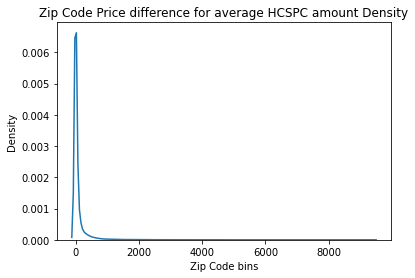

In [ ]:
#price difference per zip code, per code 
#average submitted price per zipcode

#start with average price difference for each suburb 

dictionary4 ={}

for i in range(len(data["Zip Code of the Provider"])):
    if data["Country Code of the Provider"][i] != "JP": #Japan ruins the graph a bit by having 7 digits
      if data["Zip Code of the Provider"][i] in dictionary4:
          dictionary4[data["Zip Code of the Provider"][i]] += [abs(descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][i]] - data["Average Submitted Charge Amount"][i])]
      
      else:
          dictionary4[data["Zip Code of the Provider"][i]] = [abs(descriptors["Average Submitted Charge Amount"][data["HCPCS Code"][i]]  - data["Average Submitted Charge Amount"][i] ) ]

#print(dictionary4)
x = [val for val in dictionary4.keys()]
y=[sum(val)/len(val) for val in dictionary4.values()]


plt.plot(x,y, marker = "o", linestyle = "")
#plt.ylim(0,6000)
#plt.xlim(0,6000)
plt.title("Absolute value of the averages of all HCSPC codes in a single area's average submitted charge, less that hscbc codes average for each zip code")
plt.xlabel("ZIP")
plt.show()

# To investigate the peaks, if they are in richer areas 

max_y =[]
max_y_zip =[]
for num in range(10):
  max_y.append(max(y))
  index = y.index(max_y[-1])
  max_y_zip.append(x[index])
  y.remove(max_y[-1])
  x.remove(max_y_zip[-1])


for i in range(len(max_y)):
  max_y[i] = [max_y[i], max_y_zip[i]]

print(max_y)

sns.kdeplot(y)
plt.xlabel("Zip Code bins")
plt.title("Zip Code Price difference for average HCSPC amount Density")
plt.show()

#price difference for zip code is close to zero


#checking area effects

descriptors2 = data.groupby(["Zip Code of the Provider"]).mean()

dictionary4 ={}

for i in range(len(data["Zip Code of the Provider"])):
    if data["Country Code of the Provider"][i] != "JP": #Japan ruins the graph a bit by having 7 digits
      if data["Zip Code of the Provider"][i] in dictionary4:
          dictionary4[data["Zip Code of the Provider"][i]] += [abs(descriptors2["Average Submitted Charge Amount"][data["Zip Code of the Provider"][i]] - data["Average Submitted Charge Amount"][i])]
      
      else:
          dictionary4[data["Zip Code of the Provider"][i]] = [abs(descriptors2["Average Submitted Charge Amount"][data["Zip Code of the Provider"][i]]  - data["Average Submitted Charge Amount"][i] ) ]

#print(dictionary4)
x = [val for val in dictionary4.keys()]
y=[sum(val)/len(val) for val in dictionary4.values()]


plt.plot(x,y, marker = "o", linestyle = "")
#plt.ylim(0,6000)
#plt.xlim(0,6000)
plt.title("Averages of all submitted values by zip code, less that mean by zip code for each zip code")
plt.xlabel("ZIP")
plt.show()

# To investigate the peaks, if they are in richer areas 

max_y =[]
max_y_zip =[]
for num in range(10):
  max_y.append(max(y))
  index = y.index(max_y[-1])
  max_y_zip.append(x[index])
  y.remove(max_y[-1])
  x.remove(max_y_zip[-1])


for i in range(len(max_y)):
  max_y[i] = [max_y[i], max_y_zip[i]]

print(max_y)

sns.kdeplot(y)
plt.xlabel("Zip Code bins")
plt.title("Zip Code Price difference for average amount by zip code Density")
plt.show()



### Graph of the frequeny of each state in the data set

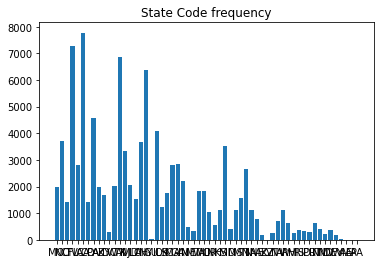

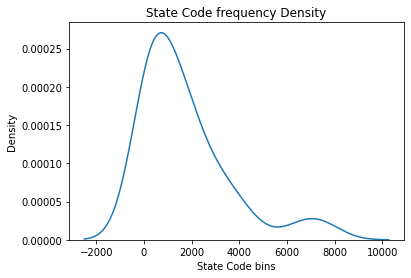

In [ ]:
#distribution of observations per place

dictionary6 = {}

for i in range(len(data["State Code of the Provider"])):
      if data["State Code of the Provider"][i] in dictionary6:
        dictionary6[data["State Code of the Provider"][i]] += 1
      else:
        dictionary6[data["State Code of the Provider"][i]] = 1

plt.bar(dictionary6.keys(), dictionary6.values())
plt.title("State Code frequency")

plt.show()

#some states are favoured in the data selection, could show where higher occurances happen 

sns.kdeplot(dictionary6.values())
plt.xlabel("State Code bins")
plt.title("State Code frequency Density")
plt.show()

### Graph of the frequency of provider types 

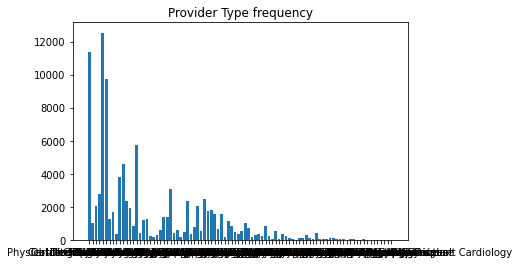

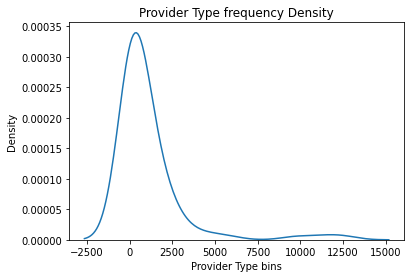

In [ ]:
#distribution of observatioons per provider type 

dictionary7 = {}

for i in range(len(data["Provider Type"])):
      if data["Provider Type"][i] in dictionary7:
        dictionary7[data["Provider Type"][i]] += 1
      else:
        dictionary7[data["Provider Type"][i]] = 1

plt.bar(dictionary7.keys(), dictionary7.values())
plt.title("Provider Type frequency")
plt.show()

#again there is a high concentration in cetain categories, which you would expect


sns.kdeplot(dictionary7.values())
plt.xlabel("Provider Type bins")
plt.title("Provider Type frequency Density")
plt.show()

## End of main data exploration 

# Main Functions Used 

In [ ]:
#Shapiro-Wilk Test 
def normalcy_text(data_series):
  stat,p = stats.shapiro(data_series)

  print("syay =%.3f, p = %.3f\n" %(stat,p))

  if p>0.05:
    print("Probably Gaussian")
  else:
    print("Probably not Gaussian")

In [ ]:
#Transform uniform distrubution into normal distribution, from earlier seeing that there are some issues 
#also standardises 

def normal_transform(df):
  
  
  features_transform = list(df.columns)    

  '''

  for i in range(len(features_transform)):

    stats.probplot(df[features_transform[i]], dist ="norm", plot=pylab)
    pylab.show()
    sns.kdeplot(df[features_transform[i]])
    plt.show()
  '''
  pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
  X = pt.fit_transform(df[features_transform ])

  new_df = pd.DataFrame()
  
  for i in range(len(features_transform)):

    #stats.probplot(X[:,i], dist ="norm", plot=pylab)
    #pylab.show()
    #sns.kdeplot(X[:,i])
    #plt.show()
    new_df[features_transform[i]] = X[:,i]
  
  return new_df


In [ ]:
def standardise(df):
    df_new = df.copy()
    data_columns = df_new.columns
    
    std = StandardScaler()
    df_new = std.fit_transform(df_new)
    df_new = pd.DataFrame(df_new, columns = data_columns)

    return df_new


In [ ]:
# training test set do we need?? training i think is a little unnecessary 

def train_test(df):
  y = np.zeros(len(df.index))

  X_train, X_test, t_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)
  return X_train, X_test, t_train, y_test


In [ ]:

#LOF

def lof_graph(df, anomaly_fraction = 0.0025, neighbors = 250, to_graph = False):

  anomaly_fraction                                                                      #This was selected as graphs look better with sparse data 
  lof = LocalOutlierFactor(n_neighbors = neighbors, contamination=anomaly_fraction)     #Also chose n_neighbours for the same reaon, especially with 100,000 obs 

  y_pred = lof.fit_predict(df)

  lofs_index = where(y_pred ==-1)
  values = df.iloc[lofs_index]
  
  if to_graph:
    graphed =[]
    for i in range(len(df.columns)):
      for j in range(len(df.columns)):
        if i != j and [list(df.columns)[i],list(df.columns)[j]] not in graphed and [list(df.columns)[j], list(df.columns)[i]] not in graphed:

          plt.scatter(df.iloc[:,i], df.iloc[:,j])
          plt.scatter(values.iloc[:,i],values.iloc[:,j], color='r')
          plt.title([list(df.columns)[i],list(df.columns)[j]])
          plt.show()

          graphed.append([list(df.columns)[i],list(df.columns)[j]])

  return lofs_index

#thresh = quantile(lof, .03)
#print(thresh)

'''
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1
y_test_pred = model.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1
'''

#best indicator is medicare participation indicator 
""

''

In [ ]:
# remake the lof model using PCA features
#will do so on the original set df3_new

def make_pca(df, num_components = 3):

  pca = PCA(n_components=num_components)
  principal_components = pca.fit_transform(df)
  print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

  #print(pca.singular_values_)

  #print(pca)
  headings = []
  for i in range(num_components):
    headings.append("principal_component_"+str(i))

  principalDf = pd.DataFrame(data = principal_components, columns = headings)

  return principalDf


### oneshotsvm left out because took too long 

In [ ]:
#Takes too long 

'''

clf = OneClassSVM().fit(df3_new)
pred = clf.predict(df3_new)


anom_index = where(pred==-1)
values = df3_new.iloc[anom_index]

for i in range(len(df3_new.columns)):
  for j in range(len(df3_new.columns)):
    if i != j:

      plt.scatter(df3_new.iloc[:,i], df3_new.iloc[:,j])
      plt.scatter(values.iloc[:,i],values.iloc[:,j], color='r')
      plt.title([list(df3_new.columns)[i],list(df3_new.columns)[j]])
      plt.show()
'''
""

''

In [ ]:
#Try again using the PCA features 


#dont run again, takes forever but works 

'''

clf = OneClassSVM().fit(principalDf)
pred = clf.predict(principalDf)


anom_index = where(pred==-1)
values = principalDf.iloc[anom_index]

for i in range(len(principalDf.columns)):
  for j in range(len(principalDf.columns)):
    if i != j:

      plt.scatter(principalDf.iloc[:,i], principalDf.iloc[:,j])
      plt.scatter(values.iloc[:,i],values.iloc[:,j], color='r')
      plt.title([list(principalDf.columns)[i],list(principalDf.columns)[j]])
      plt.show()

'''
""

''

In [ ]:
def isolation_graph(df, to_graph = False):

  ''' Takes input as a data frame, and perforoms an isolatioon forest model, and prints graphs comparing respective variables, will also return the indexes of the values for comparison with other predictors '''
  df_np = df.to_numpy() #isolation forests prefer data in this format


  model = IsolationForest(n_estimators=100, max_samples=1024, 
                          contamination=0.0025, max_features=1.0,  
                          verbose=1, warm_start=False, random_state=42)   #max_samples auto = 256, contamination can also be auto 
  model.fit(df_np)


  pred = model.predict(df) #assigning prediction values

  anom_index = where(pred==-1)     #taking indexes where pred ==-1
  values = df.iloc[anom_index]  #applying indexes, giving anomaly values index 

  if to_graph:
    graphed =[]
    for i in range(len(df.columns)):         #iterating through elements, to get a visual representation of anomalies and real value for each pairing. 
      for j in range(len(df.columns)):
        if i != j and [list(df.columns)[i],list(df.columns)[j]] not in graphed and [list(df.columns)[j], list(df.columns)[i]] not in graphed:


          plt.scatter(df.iloc[:,i], df.iloc[:,j])
          plt.scatter(values.iloc[:,i],values.iloc[:,j], color='r')
          plt.title([list(df.columns)[i],list(df.columns)[j]])
          plt.show()
          
          graphed.append([list(df.columns)[i],list(df.columns)[j]])

  return anom_index

#graphing with scores instead
'''
scores=model.decision_function(df3_new)

thresh = quantile(scores, 0.0025)
print(thresh)
index = where(scores<=thresh)
values = df3_new.iloc[index]

'''
""

''

# Further Preprocessing after data exploration

### Normalcy Test

In [ ]:
normalcy_text(df1["AverageSubmittedChargeAmount"])

syay =0.240, p = 0.000

Probably not Gaussian


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Preprocessing: Covariance 

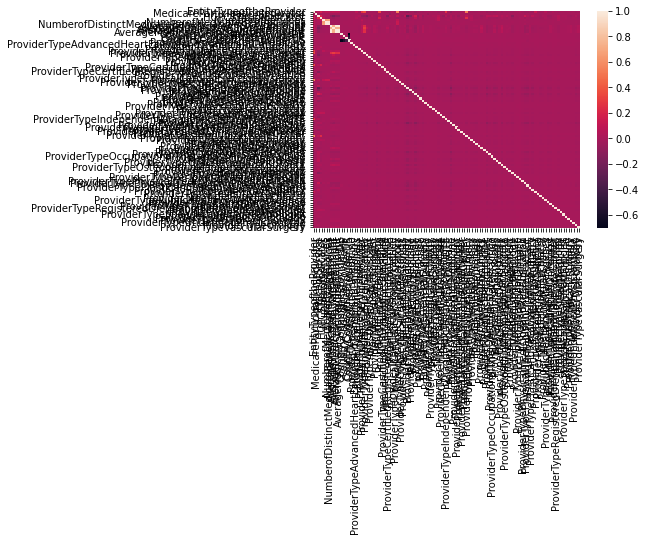

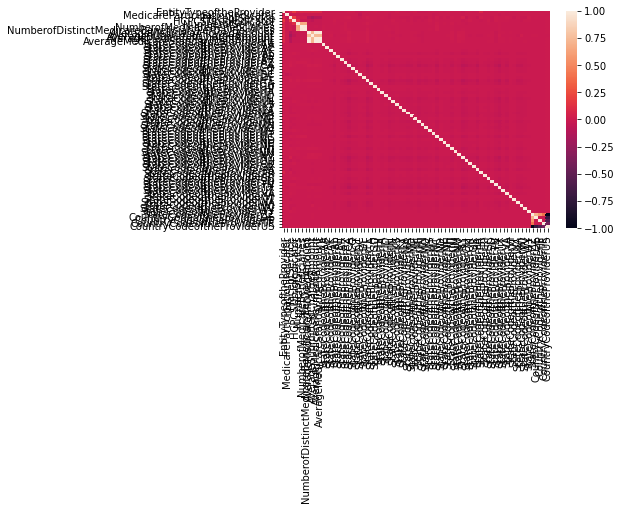

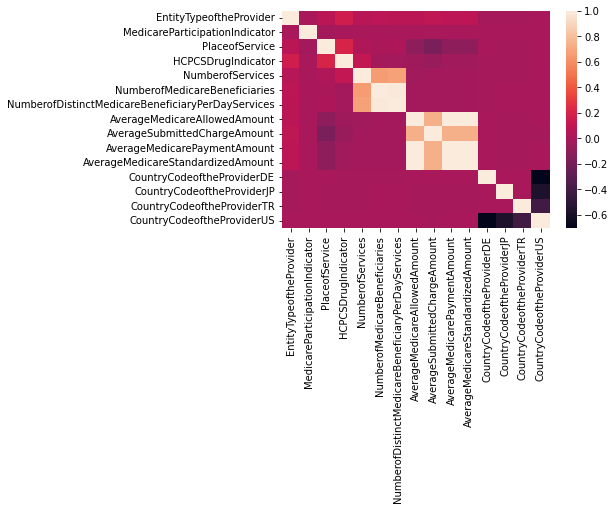

In [ ]:
#correlation df1

corr = df1.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

#correlation d2

corr =df2.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

#due to the complexity will look at the numerical values from the data set, before all of the one hot encoding 


corr =df3.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

# there is a high correlatio between the number of distinct medicare benificiary / dat and number of medican benificiaryies - which makes sense as well as a lighter relationsip between number of services and the earlier 2, which makes snse
#There is also a relationship between the average medical payment amount and the other average values, as well as a higher correlation between the others 

#May have to condense some of this informations. 

,EntityTypeoftheProvider,MedicareParticipationIndicator,PlaceofService,HCPCSDrugIndicator,NumberofServices,NumberofMedicareBeneficiaries,AverageSubmittedChargeAmount,AverageMedicarePaymentAmount,CountryCodeoftheProviderDE,CountryCodeoftheProviderJP,CountryCodeoftheProviderTR,CountryCodeoftheProviderUS
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.042540,0.999690,0.616160,0.06198,239.671424,89.809310,354.550451,77.358795,0.000030,0.000020,0.000010,0.999940
std,0.201819,0.017604,0.486322,0.24112,2493.187089,1109.616902,1062.608271,199.718813,0.005477,0.004472,0.003162,0.007746
min,0.000000,0.000000,0.000000,0.00000,11.000000,11.000000,0.010000,0.008679,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.00000,21.000000,17.000000,57.647876,19.335228,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.00000,43.000000,32.000000,146.000000,47.020176,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.00000,118.000000,75.000000,298.932111,84.894452,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,282739.000000,190306.000000,62694.000000,16067.300000,1.000000,1.000000,1.000000,1.000000


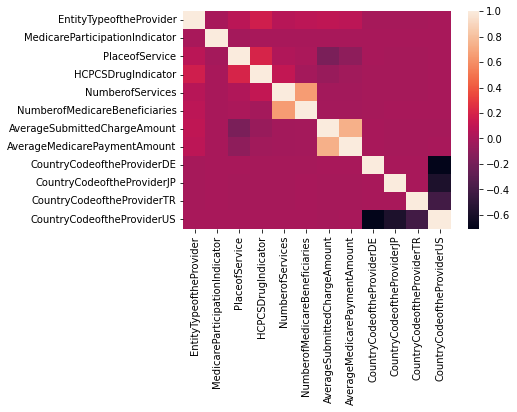

In [ ]:
# dropping columns with covariance 

new_drops =["NumberofDistinctMedicareBeneficiaryPerDayServices", #keeping Number of Medicare Beneficiaries, as this would have been used for creating the averages 
            "AverageMedicareAllowedAmount", #keeping payment and return, might also keep allowed 
            "AverageMedicareStandardizedAmount"
          ]

df1 = df1.drop(new_drops, axis = 1)
df2 = df2.drop(new_drops, axis = 1)
df3 = df3.drop(new_drops, axis = 1)

corr =df3.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


df3.describe()

### Preprocessing - standarsise and test set creation

In [ ]:
# standardise 
df1_new = normal_transform(df1)
df2_new = normal_transform(df2)
df3_new = normal_transform(df3)


#checking skew
display(df3_new.skew())


#Train/test set
X_train1, X_test1, t_train1, y_test1 = train_test(df1_new)
X_train2, X_test2, t_train2, y_test2 = train_test(df2_new)
X_train3, X_test3, t_train3, y_test3 = train_test(df3_new)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=wher

EntityTypeoftheProvider             4.533468
MedicareParticipationIndicator    -56.770621
PlaceofService                     -0.477718
HCPCSDrugIndicator                  3.633278
NumberofServices                    0.150992
NumberofMedicareBeneficiaries       0.152913
AverageSubmittedChargeAmount       -0.002976
AverageMedicarePaymentAmount        0.018961
CountryCodeoftheProviderDE        182.568708
CountryCodeoftheProviderJP        223.603444
CountryCodeoftheProviderTR        316.227766
CountryCodeoftheProviderUS       -129.089762
dtype: float64

#  Modelling

- LOF
- LOF with PCA
- Isolation forest

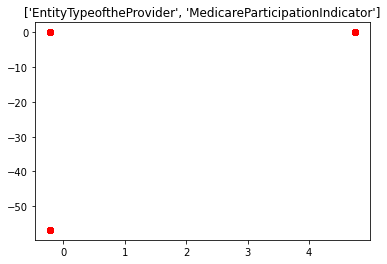

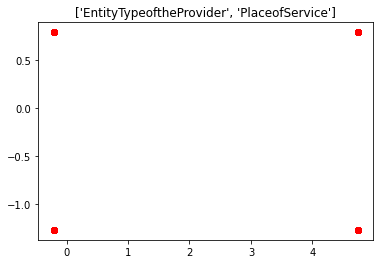

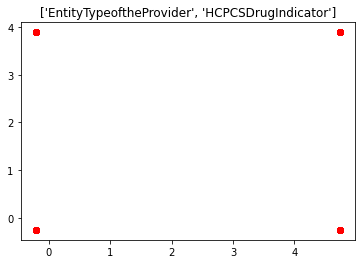

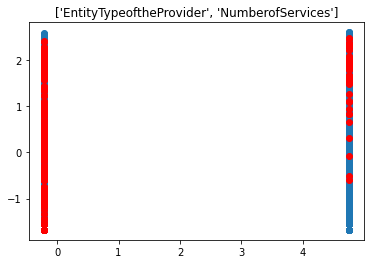

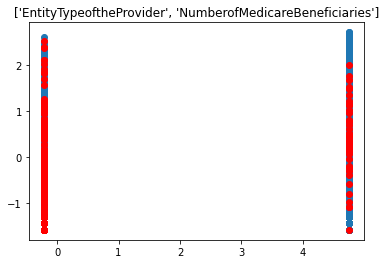

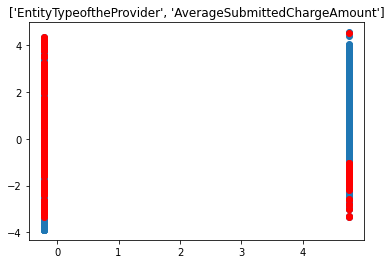

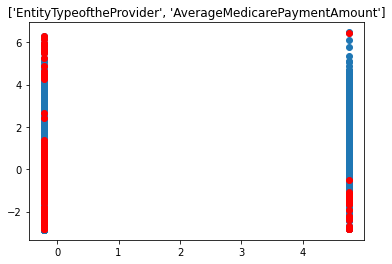

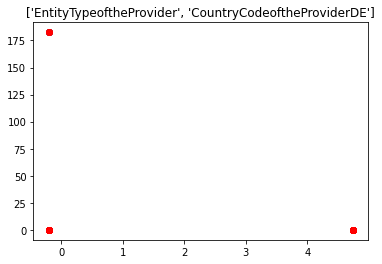

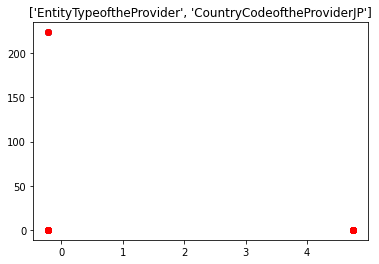

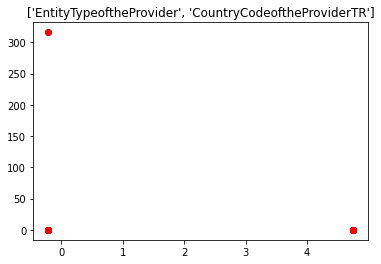

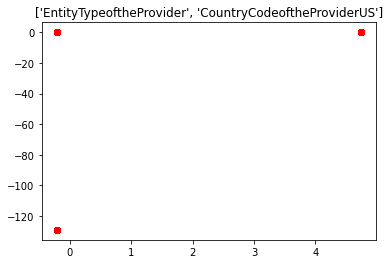

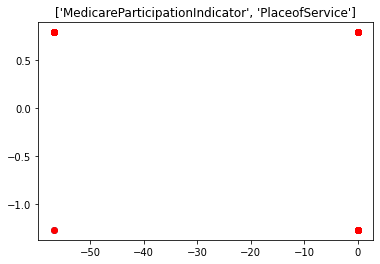

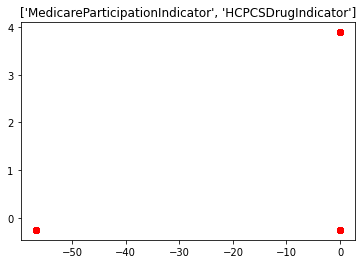

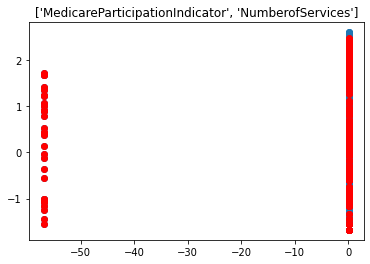

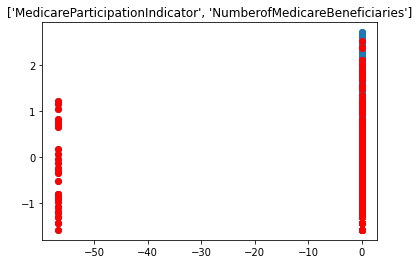

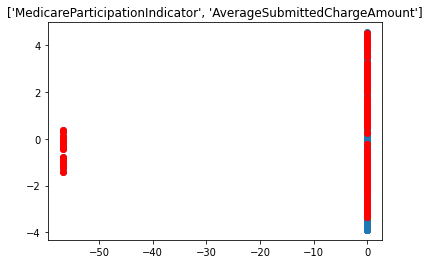

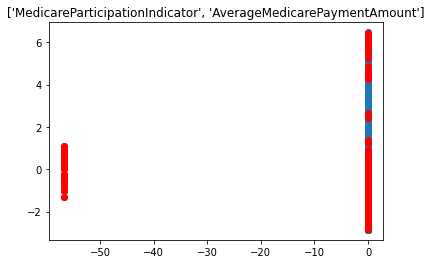

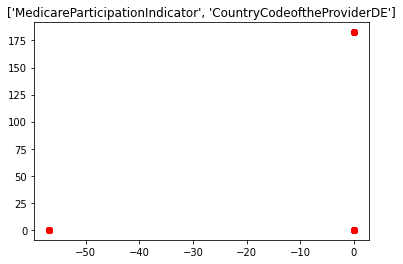

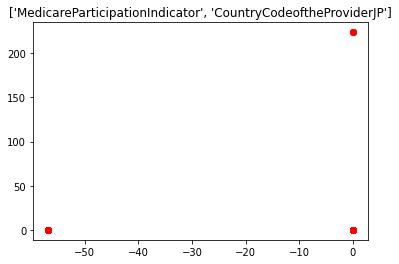

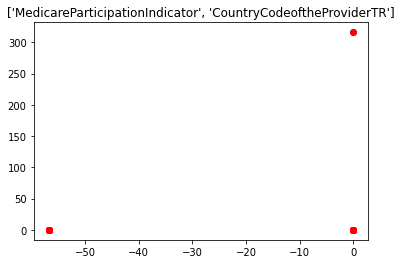

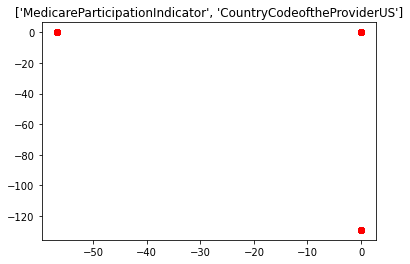

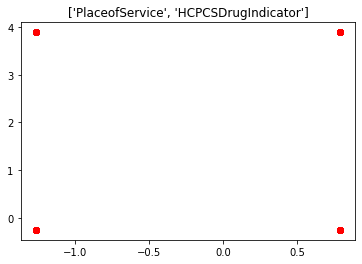

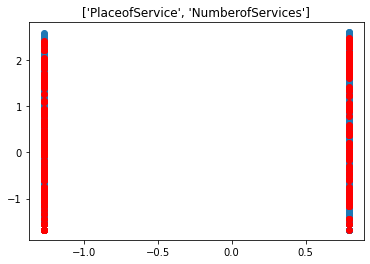

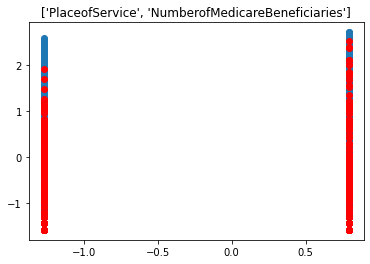

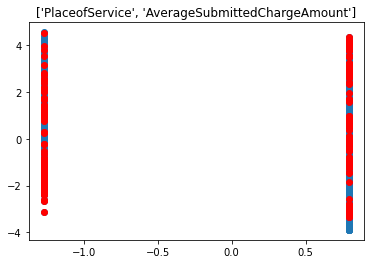

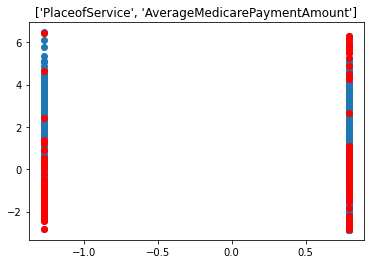

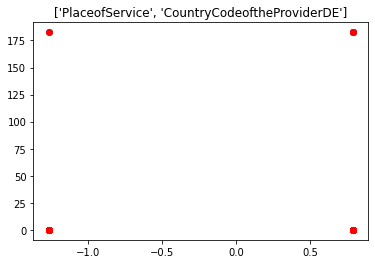

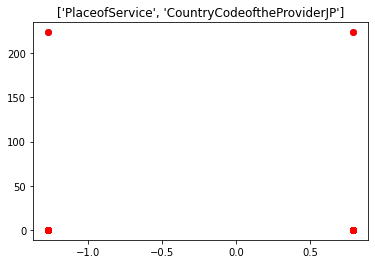

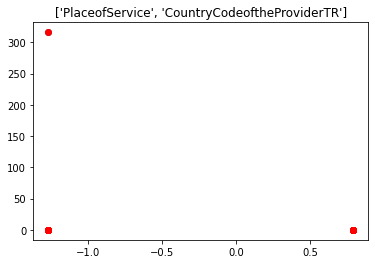

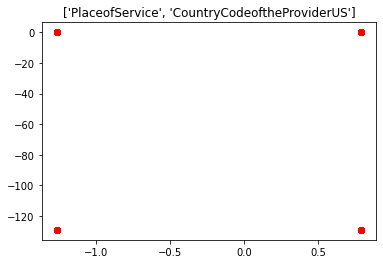

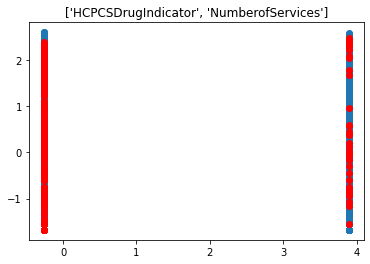

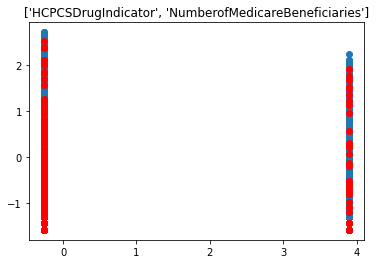

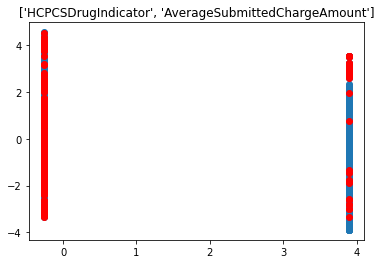

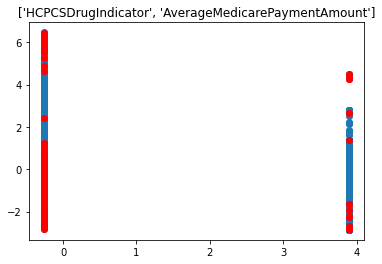

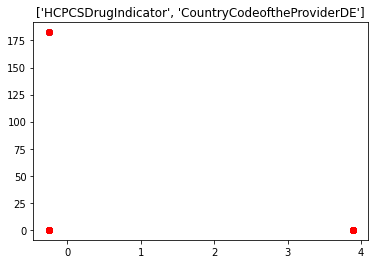

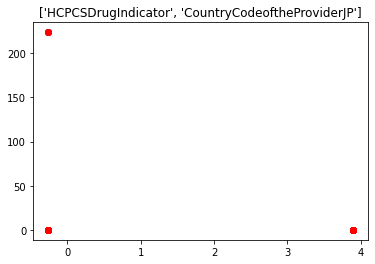

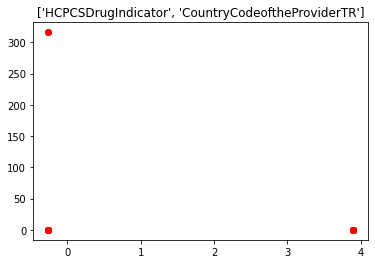

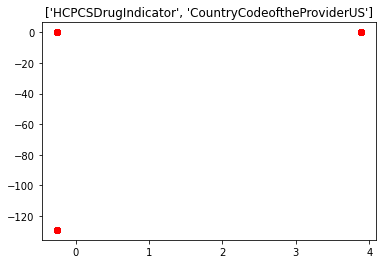

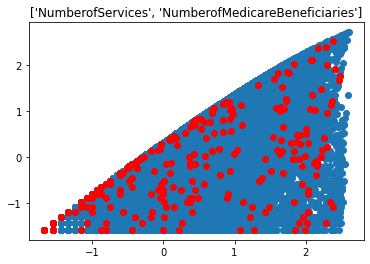

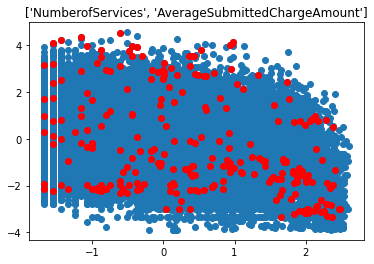

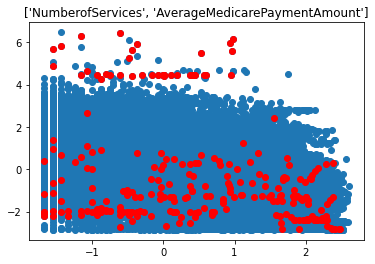

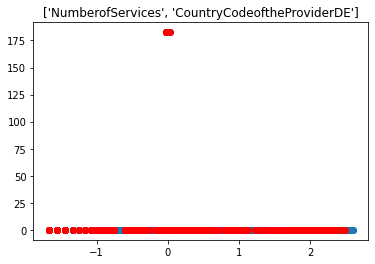

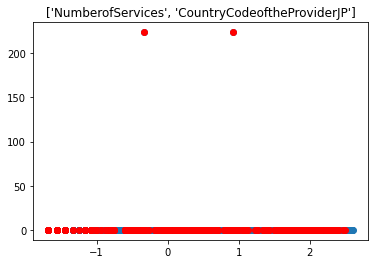

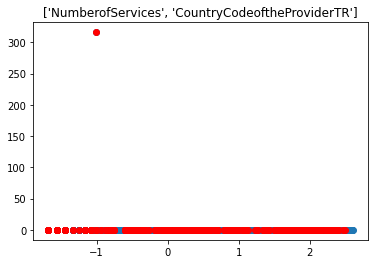

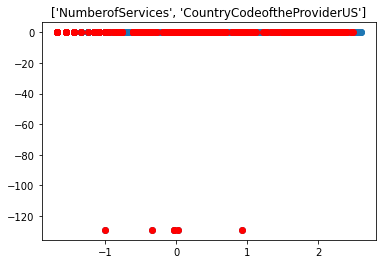

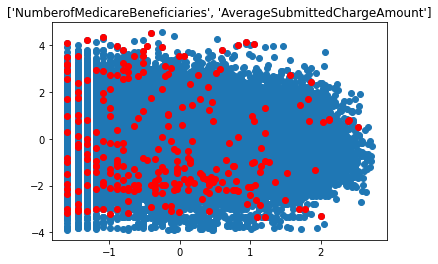

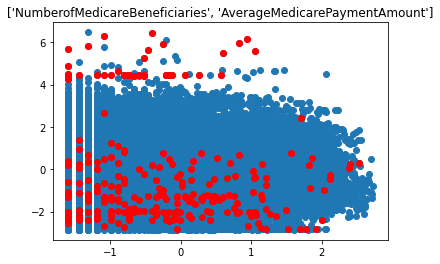

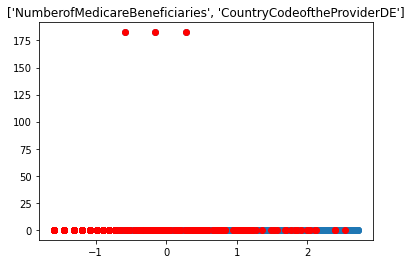

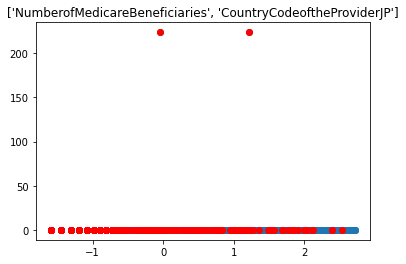

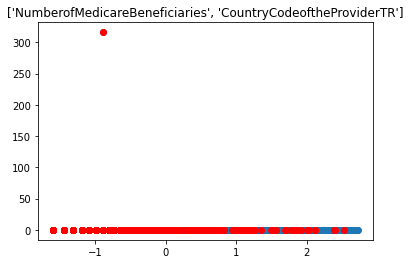

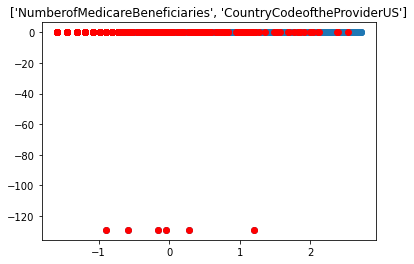

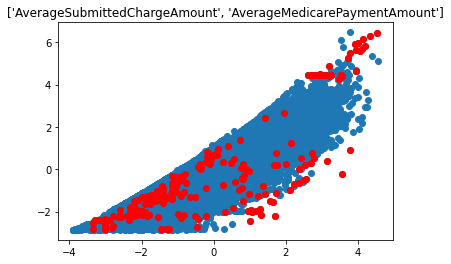

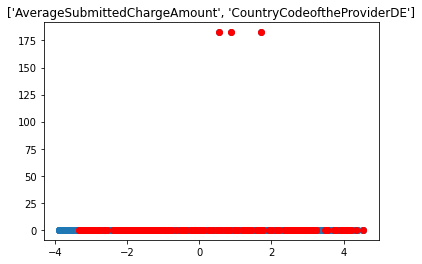

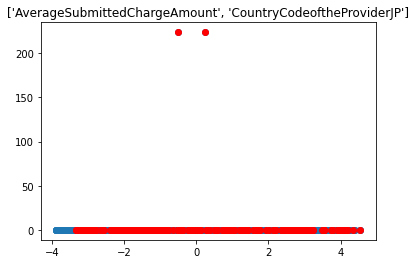

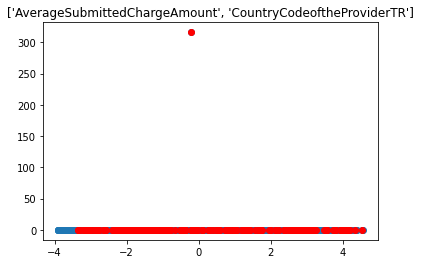

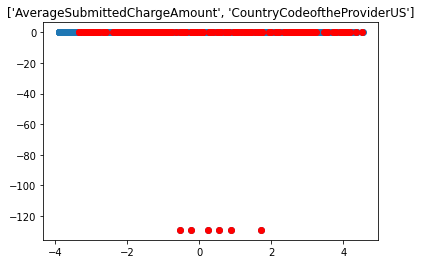

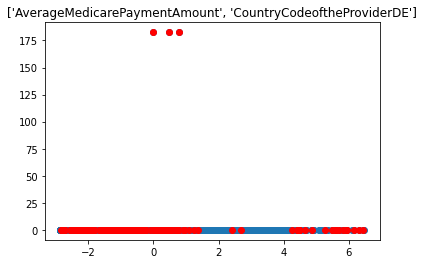

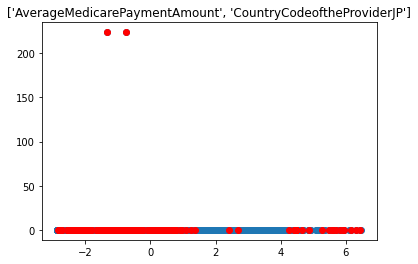

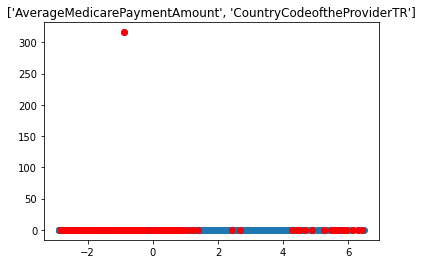

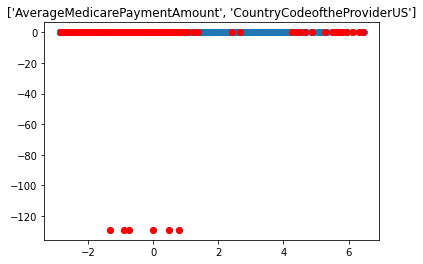

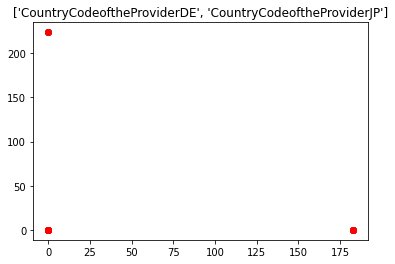

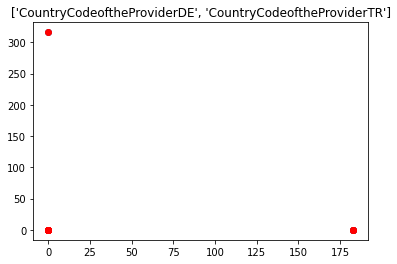

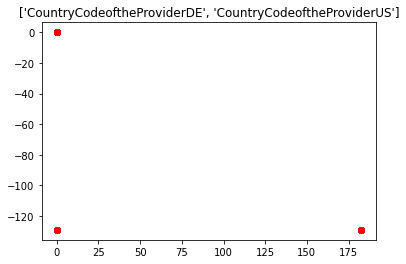

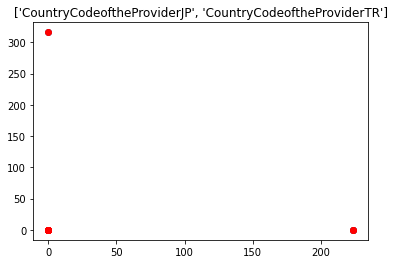

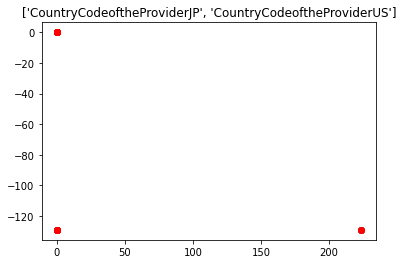

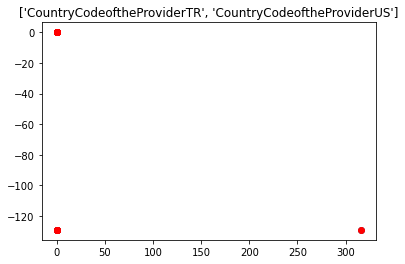

[0.02631925 0.01994114 0.01955688 0.01823377 0.01383155 0.01121213
 0.01049614 0.01035998 0.01022666 0.0101898  0.01010142 0.01004589
 0.01002174 0.00995621 0.00995034 0.00993167 0.00992253 0.00991276
 0.00990092 0.00988384 0.00988181 0.00987031 0.00986621 0.00985863
 0.00985224 0.0098463  0.00983986 0.00983672 0.00983089 0.00982843] 0.3485060452641009
[0.0428578  0.03364237 0.02488469 0.01648422 0.01522912 0.01507817
 0.01497902 0.01495264 0.01479456 0.01477741 0.01474391 0.01468329
 0.01466889 0.01463813 0.01460238 0.01458478 0.01457815 0.01453755
 0.0145247  0.01450396 0.01449303 0.01448214 0.01446466 0.01445746
 0.01443494 0.01442098 0.0144132  0.01440202 0.01438228 0.01437577] 0.49807222600396495
[0.195389   0.16666365 0.14418777] 0.5062404188218822


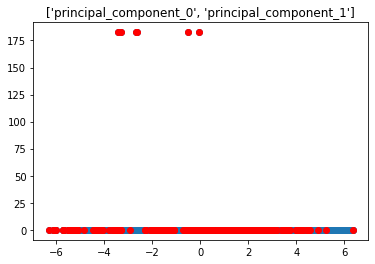

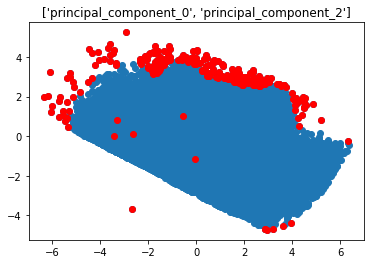

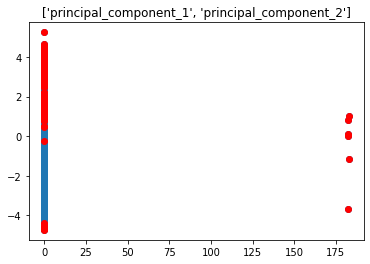

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but Isola

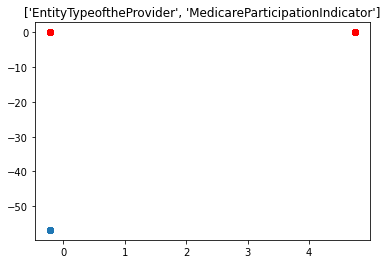

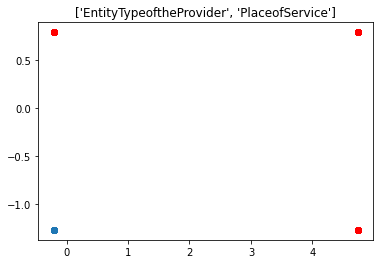

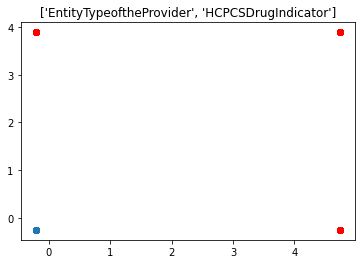

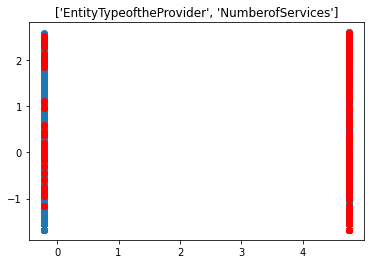

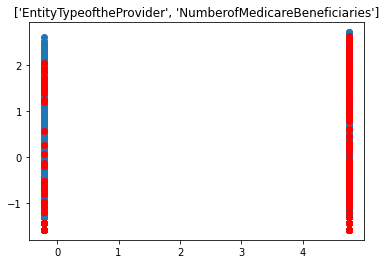

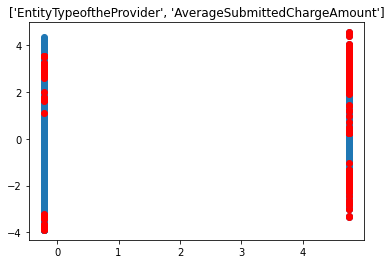

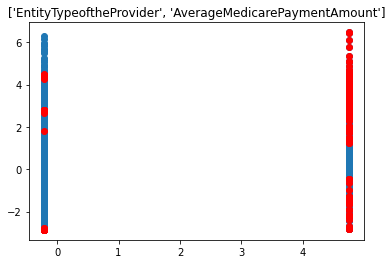

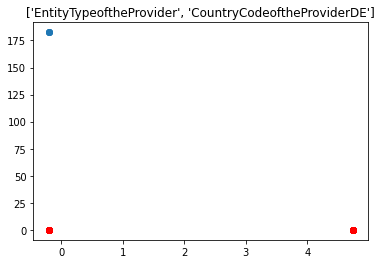

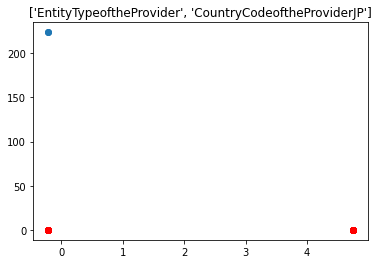

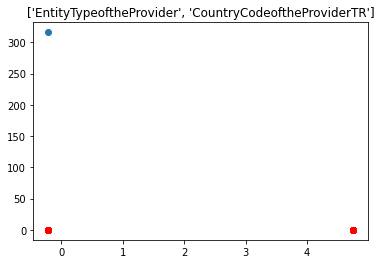

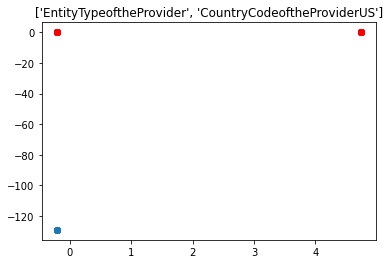

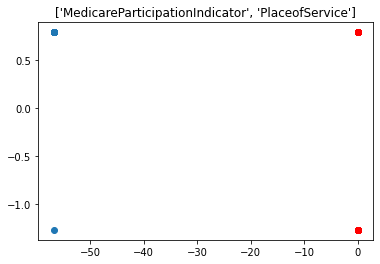

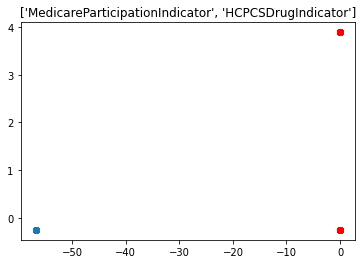

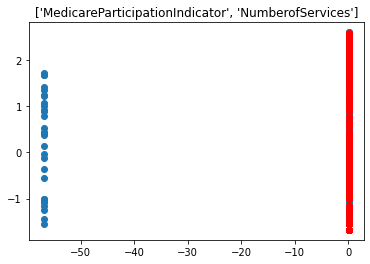

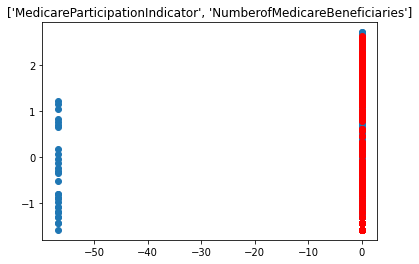

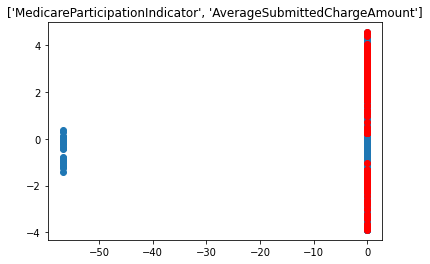

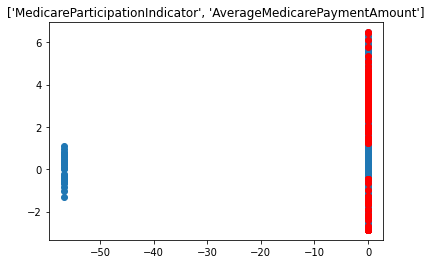

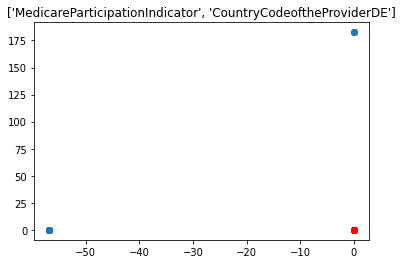

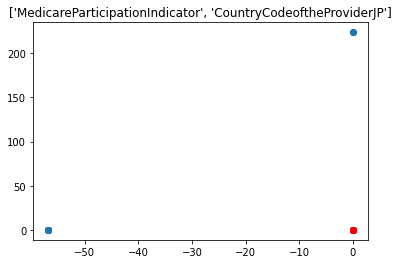

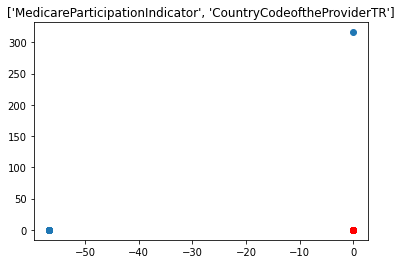

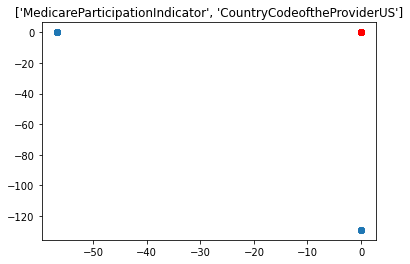

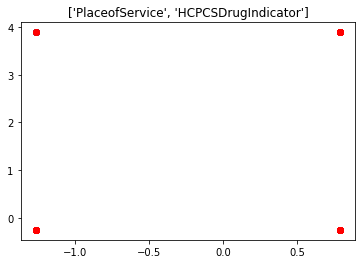

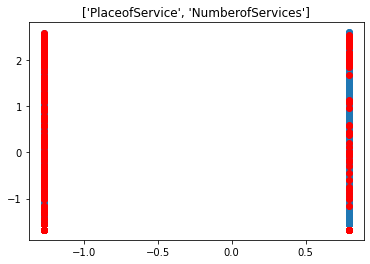

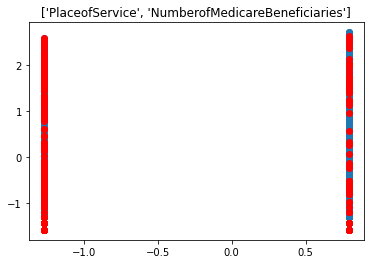

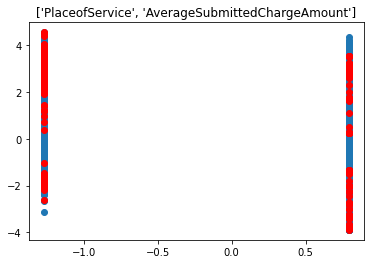

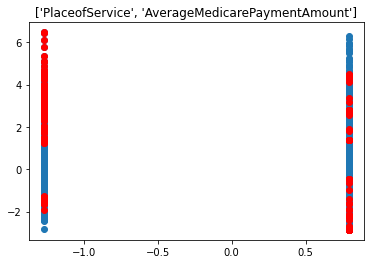

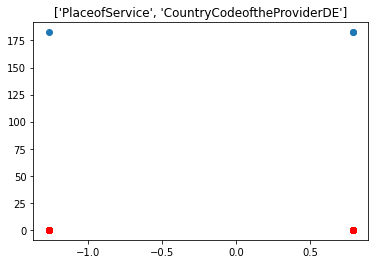

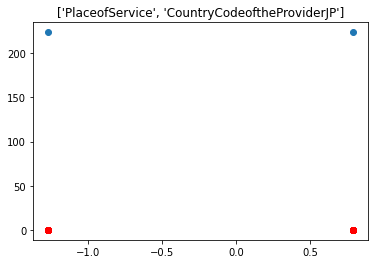

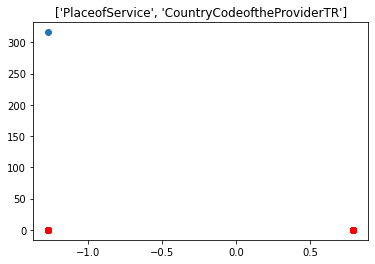

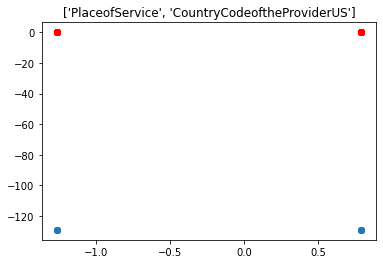

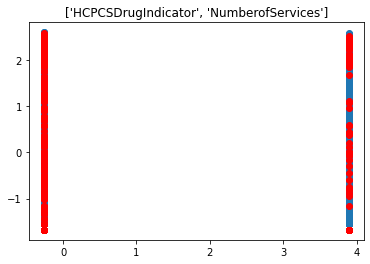

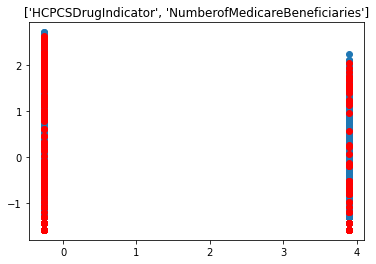

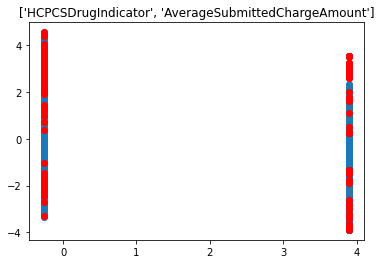

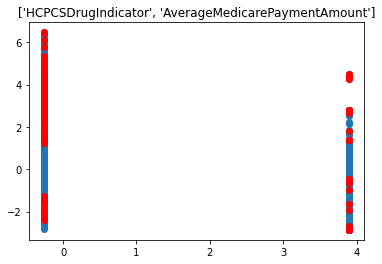

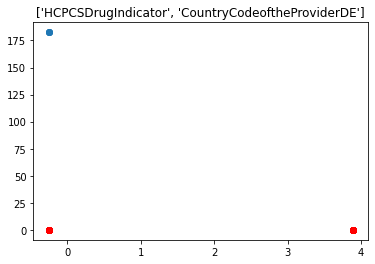

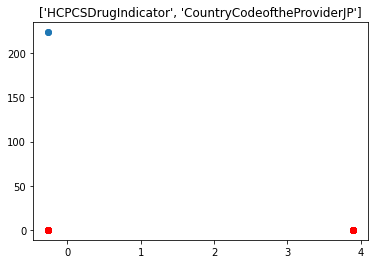

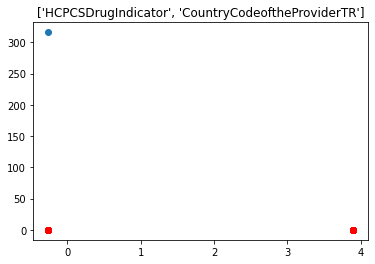

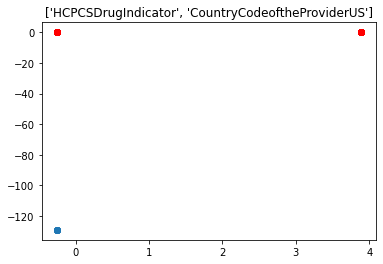

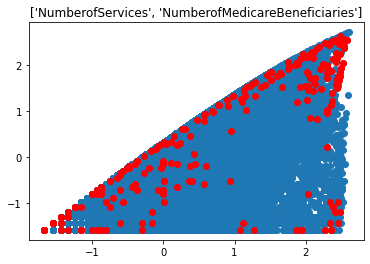

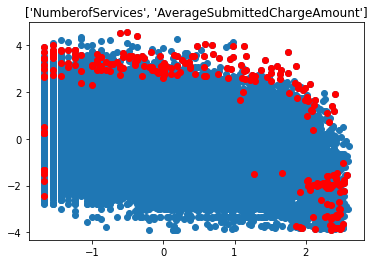

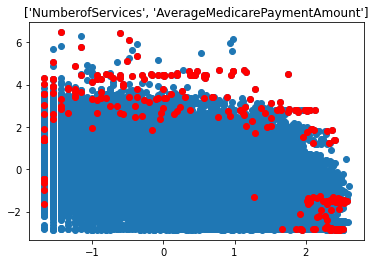

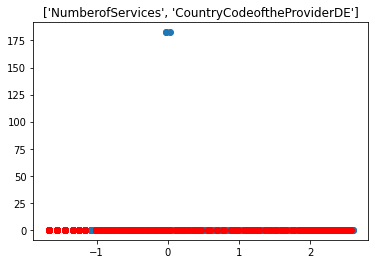

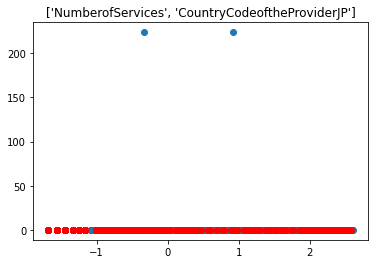

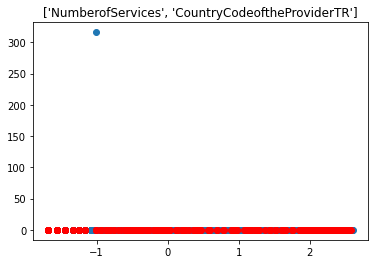

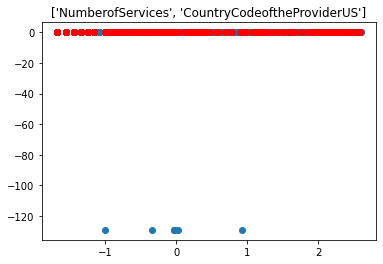

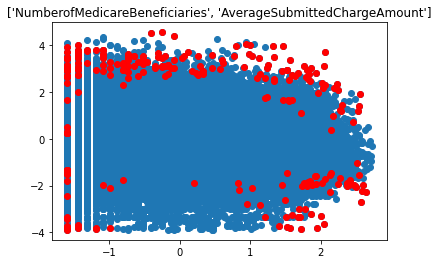

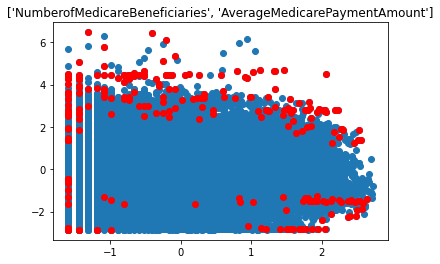

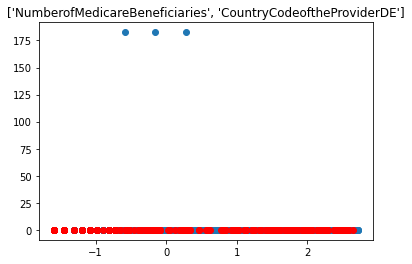

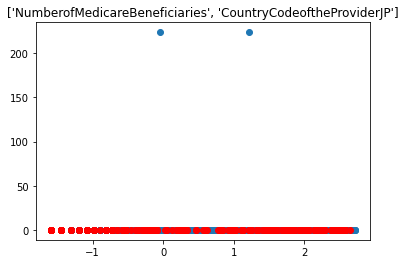

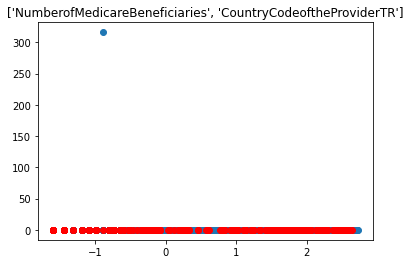

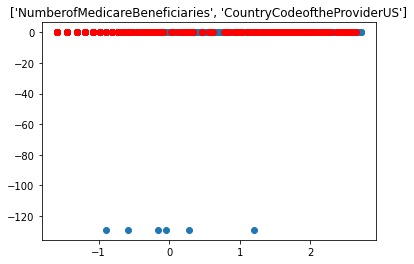

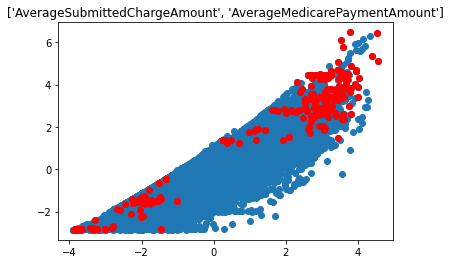

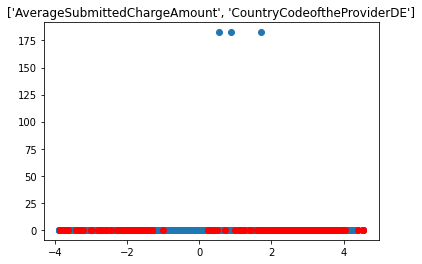

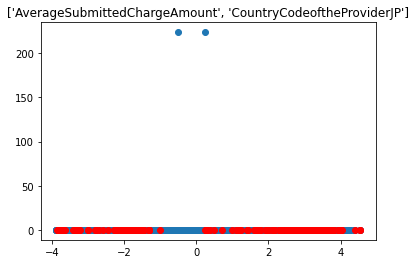

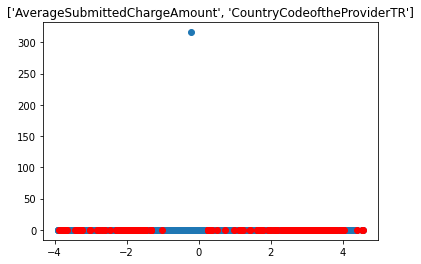

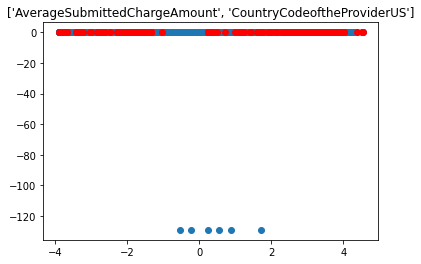

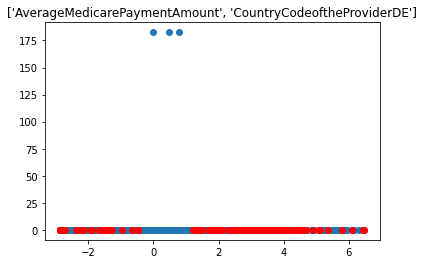

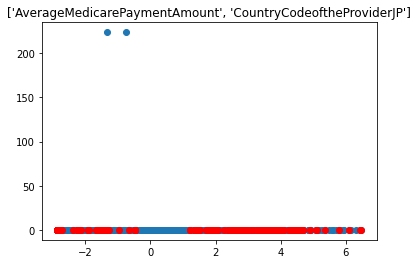

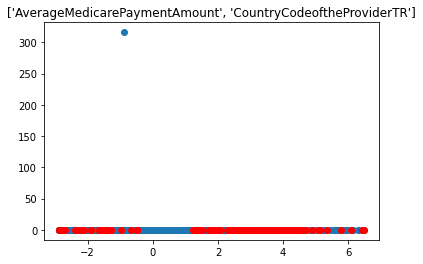

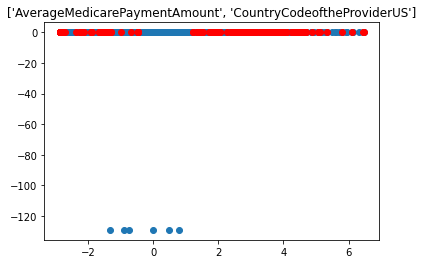

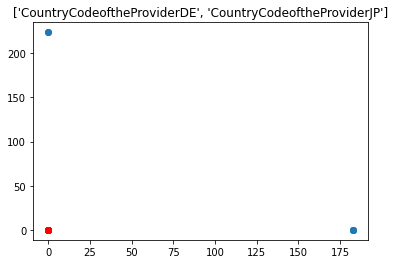

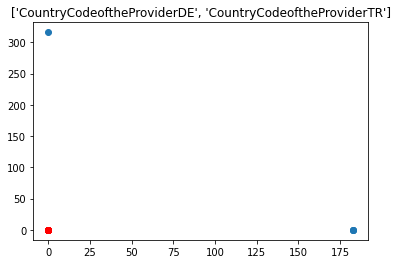

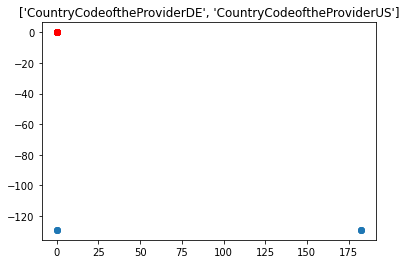

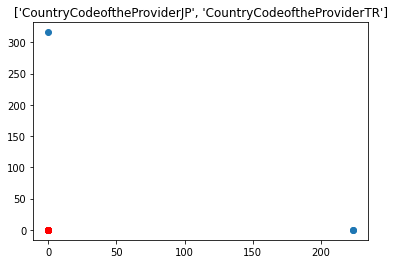

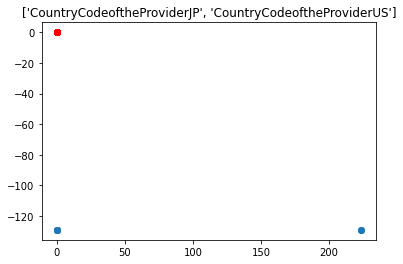

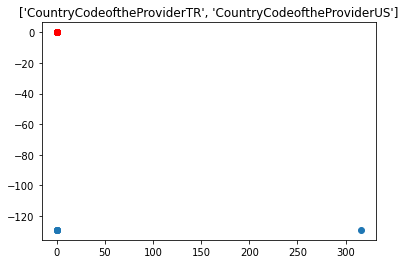

In [ ]:
#Running models - takes 21 minutes to run them all 

#testing lof, and returning the index for the identified anomalies 

lof_index_df1_1 = lof_graph(df1_new)
lof_index_df2_1 = lof_graph(df2_new)
lof_index_df3_1 = lof_graph(df3_new, to_graph = True)

#comparison by removing the binary features that are highly skewed 

#high_skew =["MedicareParticipationIndicator", "CountryCodeoftheProviderDE", "CountryCodeoftheProviderJP", "CountryCodeoftheProviderTR", "CountryCodeoftheProviderUS"]
#df3_new2 = df3_new.drop(high_skew, axis = 1)
#lof_index2 = lof_graph(df3_new2)
#print(len(lof_index2))

#There is a weird line that can be seen on the averageMedicarePaymentAmount and AverageSubmittedChargeAmount, which appears high, and linear, amd also higher amounts, which would be expected of fraud, there are also lower more conspicious
#ones scattered all over, that can only be identified by their interaction with other variables

#Reattempting lof with pca variables 

df1_pca = make_pca(df1_new, num_components = 30)
df2_pca = make_pca(df2_new, num_components = 30)
df3_pca = make_pca(df3_new, num_components = 3) #can look at output for explained variance to increase number of components 

lof_index_df1_2 = lof_graph(df1_pca)
lof_index_df2_2 = lof_graph(df2_pca)
lof_index_df3_2 = lof_graph(df3_pca, to_graph = True)

#doesnt look that good, but fist three features explain 50%

isolation_index_df1 = isolation_graph(df1_new, to_graph = False )
isolation_index_df2 = isolation_graph(df2_new, to_graph = False )
isolation_index_df3 = isolation_graph(df3_new, to_graph = True )

# Evaluation Similarity with models 

### Looking at similarities between selected abnormalities by looking at values that occured in multiple models

### Hoping to find best indicators for feature importance. 

In [ ]:
#print(lof_index_df1_1)

lof_index_dict ={}
count = 0
for array in list(lof_index_df1_1) + list(lof_index_df2_1) +  list(lof_index_df3_1):
  for i in array:
    count+=1
    if i not in lof_index_dict:
      lof_index_dict[i] = 1
    else:
      lof_index_dict[i] += 1

print("Values with two occurances in models", list(lof_index_dict.values()).count(2),"values with three occurances", list(lof_index_dict.values()).count(3), "out of", count/3)

#Output: Values with two occurances in models 19 values with three occurances 20 out of 250.0

Values with two occurances in models 19 values with three occurances 20 out of 250.0


In [ ]:
# Lof using PCA

# The variance is very undesribed by 3 variables unlike df3_new

#Completing comparison in similariy identified anomalies 

lof_index_dict ={}
count = 0
for array in list(lof_index_df1_2) + list(lof_index_df2_2) +  list(lof_index_df3_2):
  for i in array:
    count+=1
    if i not in lof_index_dict:
      lof_index_dict[i] = 1
    else:
      lof_index_dict[i] += 1

print("Values with two occurances in models", list(lof_index_dict.values()).count(2),"values with three occurances", list(lof_index_dict.values()).count(3), "out of", count/3)

# Output : Values with two occurances in models 153 values with three occurances 39 out of 250.0

#Alot more similarity with PCA terms, but i think they arent accurate with such low variance represented


# I don't think PCA can reduce the feature space well for the larger dataframes with more dummy variables 


#Increasing number of PCA variables to be used from 8 to 30 gave output:

# Output : Values with two occurances in models 37 values with three occurances 6 out of 250.0


Values with two occurances in models 44 values with three occurances 6 out of 250.0


In [ ]:
# Comparing isolation tree comparison for three sets 

lof_index_dict ={}
count = 0
for array in list(isolation_index_df1) + list(isolation_index_df2) +  list(isolation_index_df3):
  for i in array:
    count+=1
    if i not in lof_index_dict:
      lof_index_dict[i] = 1
    else:
      lof_index_dict[i] += 1

print("Values with two occurances in models", list(lof_index_dict.values()).count(2),"values with three occurances", list(lof_index_dict.values()).count(3), "out of", count/3)

Values with two occurances in models 101 values with three occurances 8 out of 250.0


In [ ]:
# Comparing df3 on lof, lof with pca and isolation forest

lof_index_dict ={}
count = 0
for array in list(lof_index_df3_1) + list(lof_index_df3_2) +  list(isolation_index_df3):
  for i in array:
    count+=1
    if i not in lof_index_dict:
      lof_index_dict[i] = 1
    else:
      lof_index_dict[i] += 1

print("Values with two occurances in models", list(lof_index_dict.values()).count(2),"values with three occurances", list(lof_index_dict.values()).count(3), "out of", count/3)

Values with two occurances in models 119 values with three occurances 3 out of 250.0


In [ ]:
# Comparing all models with all data sets 
#based on assumption that there are 9 models, this isnt generalised for more or less models

lof_index_dict ={}
count = 0
for array in list(lof_index_df1_1) + list(lof_index_df2_1) +  list(lof_index_df3_1) + list(lof_index_df1_2) + list(lof_index_df2_2) +  list(lof_index_df3_2) + list(isolation_index_df1) + list(isolation_index_df2) +  list(isolation_index_df3) :
  for i in array:
    count+=1
    if i not in lof_index_dict:
      lof_index_dict[i] = 1
    else:
      lof_index_dict[i] += 1

match_9 = list(lof_index_dict.values()).count(9)
print("Values with 9 occuranes", match_9)
match_8 =  list(lof_index_dict.values()).count(8)
print("Values with 8 occuranes", match_8)
match_7 =  list(lof_index_dict.values()).count(7)
print("Values with 7 occuranes", match_7)
match_6 =  list(lof_index_dict.values()).count(6)
print("Values with 6 occuranes", match_6)
match_5 =  list(lof_index_dict.values()).count(5)
print("Values with 5 occuranes", match_5)
match_4 =  list(lof_index_dict.values()).count(4)
print("Values with 4 occuranes", match_4)
match_3 =  list(lof_index_dict.values()).count(3)
print("Values with 3 occuranes", match_3)
match_2 =  list(lof_index_dict.values()).count(2)
print("Values with 2 occuranes", match_2)
print("Out of", count / 9)

#Output:

#Values with 9 occuranes 0
#Values with 8 occuranes 0
#Values with 7 occuranes 0
#Values with 6 occuranes 6
#Values with 5 occuranes 15
#Values with 4 occuranes 27
#Values with 3 occuranes 23
#Values with 2 occuranes 402
#Out of 250.0


#Lets see all the values with at elast 4 mathes

anomalies = []

if match_9:
  for i in range(match_9):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(9)])
    del lof_index_dict[anomalies[-1]]
if match_8:
  for i in range(match_8):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(8)])
    del lof_index_dict[anomalies[-1]]
if match_7:
  for i in range(match_7):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(7)])
    del lof_index_dict[anomalies[-1]]
if match_6:
  for i in range(match_6):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(6)])
    del lof_index_dict[anomalies[-1]]
if match_5:
  for i in range(match_5):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(5)])
    del lof_index_dict[anomalies[-1]]
if match_4:
  for i in range(match_4):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(4)])
    del lof_index_dict[anomalies[-1]]
if match_3:
  for i in range(match_3):
    anomalies.append(list(lof_index_dict.keys())[list(lof_index_dict.values()).index(3)])
    del lof_index_dict[anomalies[-1]]


anomalies_df1 = df1.iloc[anomalies]
display(anomalies_df1.describe())

anomalies_df2 = df2.iloc[anomalies]
anomalies_df2.describe()

Values with 9 occuranes 0
Values with 8 occuranes 0
Values with 7 occuranes 0
Values with 6 occuranes 6
Values with 5 occuranes 15
Values with 4 occuranes 26
Values with 3 occuranes 31
Values with 2 occuranes 427
Out of 250.0


,EntityTypeoftheProvider,MedicareParticipationIndicator,PlaceofService,HCPCSDrugIndicator,NumberofServices,NumberofMedicareBeneficiaries,AverageSubmittedChargeAmount,AverageMedicarePaymentAmount,CountryCodeoftheProviderDE,CountryCodeoftheProviderJP,...,ProviderTypeRegisteredDietitianorNutritionProfessional,ProviderTypeRheumatology,ProviderTypeSleepMedicine,ProviderTypeSpeechLanguagePathologist,ProviderTypeSportsMedicine,ProviderTypeSurgicalOncology,ProviderTypeThoracicSurgery,ProviderTypeUndefinedPhysiciantype,ProviderTypeUrology,ProviderTypeVascularSurgery
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0
mean,0.461538,0.602564,0.551282,0.153846,2002.961538,123.448718,7581.703116,1686.883549,0.038462,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.501745,0.492535,0.500582,0.363137,6612.319332,250.732156,13215.575327,3212.221768,0.193552,0.159085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,11.000000,11.000000,1.000000,0.084091,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,22.250000,15.000000,43.500000,25.054267,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,1.000000,1.000000,0.000000,69.000000,26.500000,156.050000,84.130000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,1.000000,1.000000,0.000000,342.250000,101.000000,10824.500000,2667.225398,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,42415.000000,1429.000000,62694.000000,16067.300000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,EntityTypeoftheProvider,MedicareParticipationIndicator,PlaceofService,HCPCSDrugIndicator,NumberofServices,NumberofMedicareBeneficiaries,AverageSubmittedChargeAmount,AverageMedicarePaymentAmount,StateCodeoftheProviderAA,StateCodeoftheProviderAE,...,StateCodeoftheProviderVT,StateCodeoftheProviderWA,StateCodeoftheProviderWI,StateCodeoftheProviderWV,StateCodeoftheProviderWY,StateCodeoftheProviderZZ,CountryCodeoftheProviderDE,CountryCodeoftheProviderJP,CountryCodeoftheProviderTR,CountryCodeoftheProviderUS
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.0,78.0,...,78.0,78.000000,78.000000,78.000000,78.0,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.461538,0.602564,0.551282,0.153846,2002.961538,123.448718,7581.703116,1686.883549,0.0,0.0,...,0.0,0.025641,0.025641,0.012821,0.0,0.076923,0.038462,0.025641,0.012821,0.923077
std,0.501745,0.492535,0.500582,0.363137,6612.319332,250.732156,13215.575327,3212.221768,0.0,0.0,...,0.0,0.159085,0.159085,0.113228,0.0,0.268194,0.193552,0.159085,0.113228,0.268194
min,0.000000,0.000000,0.000000,0.000000,11.000000,11.000000,1.000000,0.084091,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,22.250000,15.000000,43.500000,25.054267,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,69.000000,26.500000,156.050000,84.130000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,342.250000,101.000000,10824.500000,2667.225398,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,42415.000000,1429.000000,62694.000000,16067.300000,0.0,0.0,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


# Conclusion and future considerations 

### Could maybe consider dropping the country codes, as i think they are a small subgroup in the set, that will always be deetcted as an abormality and may place more relevance with them 

### Could also run train and test to get expect amount of abnormalities from samples 

### - Could try an Autoencoder or GAN to develop a fradulent set and then perform supervised techniques 